# In vivo hematopoiesis (DARLIN data)

Hematopoiesis dataset from `Li, L., ..., S.-.W. Wang, F. Camargo, Cell 186, (2023)`.

The DARLIN lineage tracing mouse was induced with Dox for lineage barcoding at E17. This dataset contains cells collected at multiple tissues (left leg, spleen, and skull) 10 weeks after induction.  We will focus on the analysis of the skull-derived cells as most blood cell types were well-represented in this dataset and study the fate bias of HSPCs in this dataset.

There is only one time point. We manually assign the early progenitor (HSPC) as the initial population with time t0, and the remaining cells as the later population with time t1. This is needed for running cospar.

In [27]:
import cospar as cs
import scanpy as sc
import pandas as pd
import scipy.sparse as ssp
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import os

## setting cospar
cs.logging.print_version()
cs.settings.verbosity=0
    
%matplotlib inline
%config InlineBackend.figure_format = 'svg' #'retina'    


## plot settings
from matplotlib import cbook, cm, colors, rcParams
cs.settings.set_figure_params(format='pdf',figsize=[4,3.5],dpi=100,fontsize=15,pointsize=2,dpi_save=300)
rcParams["axes.grid"] = False
cmap_reds=cs.pl.darken_cmap(plt.cm.Reds,scale_factor=0.9)
def find_vmax(values):
    return np.percentile(values,q=99)

figure_path=cs.settings.figure_path
#pd.options.display.max_rows = 200

Running cospar 0.3.3 (python 3.8.16) on 2023-11-22 13:50.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


## Load adata with both RNA and lineage

If the following downloading method is not working, try using this link https://westlakeu-my.sharepoint.com/:u:/g/personal/wangshouwen_westlake_edu_cn/ETiN1opaD-lFsmUOelCqXcEBU3tGJNNtdnYCREtMDqUqfA?e=BzHhr3 

Once the adata has been downloaded manually, the following code to load the data

cs.hf.read('path/to/tissue_adata_refined_20221106_joint.h5ad')

In [ ]:
adata_orig=cs.datasets.DARLIN_in_vivo_hematopoiesis()

In [3]:
# Only keep cells from skull and remove Dc (as there are few Dc) 
adata_orig=adata_orig[adata_orig.obs['tissue'].isin(['Skull'])]
adata_orig=adata_orig[adata_orig.obs['state_info']!='Dc']
adata_orig.uns['data_des']=['Skull']

adata_orig.obs['cell_type']=adata_orig.obs['cell_type'].astype(str)
adata_orig.obs['cell_type']=pd.Categorical(adata_orig.obs['cell_type']).set_categories(['HSC', 'MkP','Ery', 'Baso', 'Neu', 'Mon', 'LMPP'], ordered=True)
adata_orig.uns['cell_type_colors']=['#d62728','#ff7f0e', '#1f77b4', '#279e68',  '#aa40fc', '#8c564b', '#e377c2'] #,'#d9d9d9']
adata_orig.obs['state_info']=adata_orig.obs['cell_type'].astype(str)

/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


## Manually annotate the time info
HSPCs are annotated as the initial population (t0), and the mature population are annotated as the later population (t1)

In [4]:
time_map={'LMPP':'t0', 'HSC':'t0', 'NA':'t1','Baso':'t1', 'MkP':'t1', 'Mon':'t1',  'Ery':'t1','Neu':'t1', 'Dc':'t1'}
adata_orig.obs['time_info']=adata_orig.obs['cell_type'].map(time_map)
cs.pp.initialize_adata_object(adata_orig)

AnnData object with n_obs × n_vars = 6094 × 21406
    obs: 'library', 'batch', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'cell_type', 'state_info', 'time_info', 'tissue', 'state_info_old'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable'
    uns: 'cell_type_colors', 'clonal_time_points', 'clone_id', 'data_des', 'library_colors', 'neighbors', 'scrublet', 'time_ordering', 'tissue_colors', 'umap'
    obsm: 'X_clone', 'X_emb', 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

## Transcriptomic analysis

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


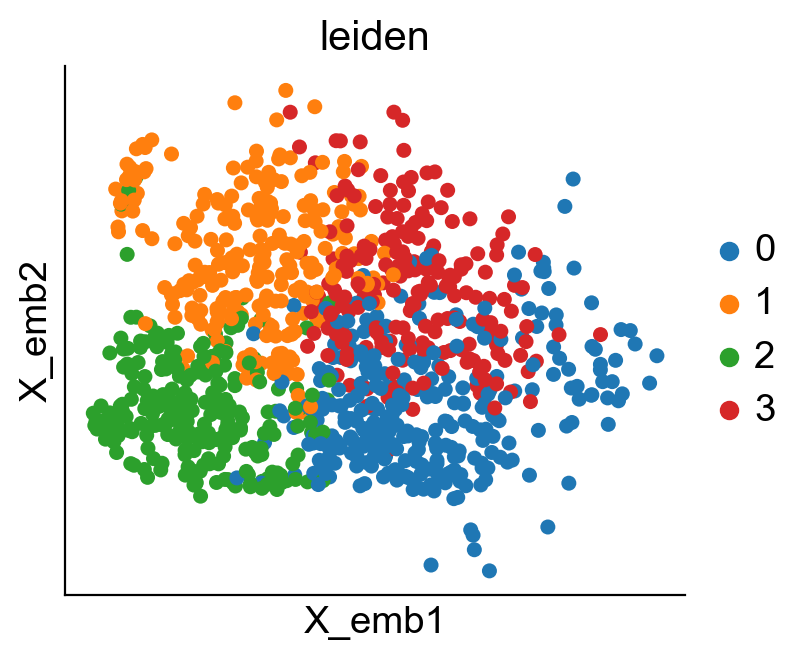

In [5]:
cs.pp.refine_state_info_by_leiden_clustering(adata_orig,selected_key='state_info',selected_values='HSC')

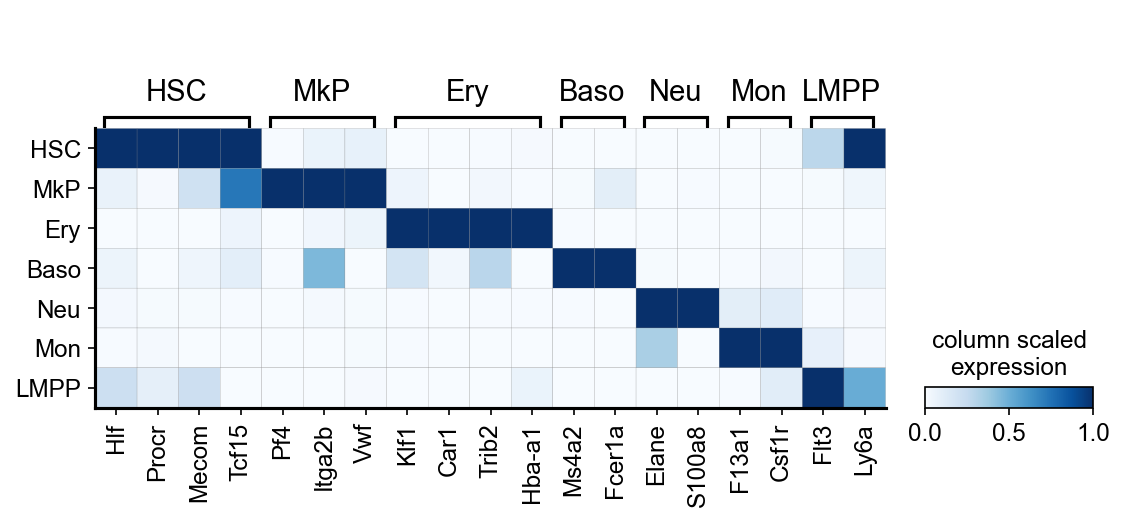

In [6]:
# markers per cell type:
celltype_genes={
'HSC' : ['Hlf', 'Procr','Mecom','Tcf15'],
'MkP' : ['Pf4', 'Itga2b', 'Vwf'],
'Ery' : ['Klf1', 'Car1','Trib2','Hba-a1' ],
'Baso' : ['Ms4a2', 'Fcer1a'],
'Neu' : [ 'Elane', 'S100a8'],
'Mon' :  ['F13a1', 'Csf1r'],
'LMPP' : ['Flt3','Ly6a']} #'Dntt','Cd79a','Cd19'

sc.settings.set_figure_params(dpi=75)#, facecolor='white')
sc.pl.matrixplot(adata_orig, celltype_genes, 
                 'cell_type', dendrogram=False, cmap='Blues', standard_scale='var', 
                 colorbar_title='column scaled\nexpression',save='matriplot_marker_genes')

In [7]:
make_gene_heatmap=False
if make_gene_heatmap:
    sc.tl.rank_genes_groups(adata_orig, 'cell_type', method='wilcoxon')
    sc.pl.rank_genes_groups(adata_orig, n_genes=10, sharey=False)

    adata_orig_sub=adata_orig[~pd.isna(adata_orig.obs['cell_type'])]
    sc.tl.filter_rank_genes_groups(adata_orig_sub)
    sc.pl.rank_genes_groups_heatmap(adata_orig_sub, n_genes=200, key='rank_genes_groups_filtered',
                                    swap_axes=True, use_raw=False, vmax=10, vmin=0, cmap='Reds', dendrogram=False,save='gene_heatmap')

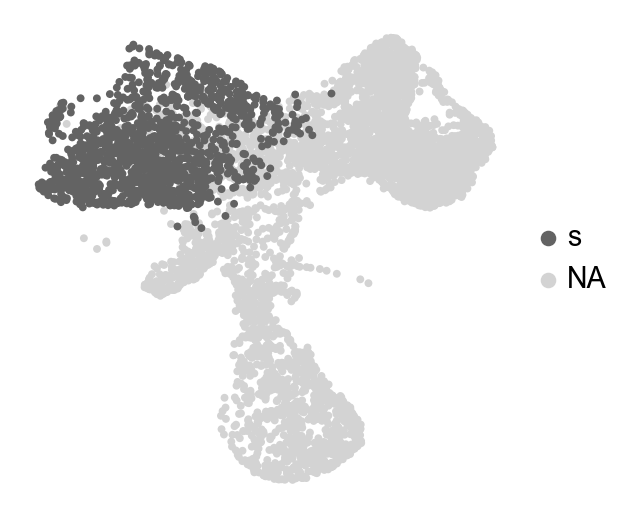

In [8]:
sc.settings.set_figure_params()
adata_orig.obs['selection']=np.nan
adata_orig.obs.loc[adata_orig.obs['time_info']=='t0','selection']='s'
sc.pl.embedding(adata_orig,color='selection',basis='X_umap',frameon=False,title='',palette={'s':'#636363'},
               save='_selection',size=50)

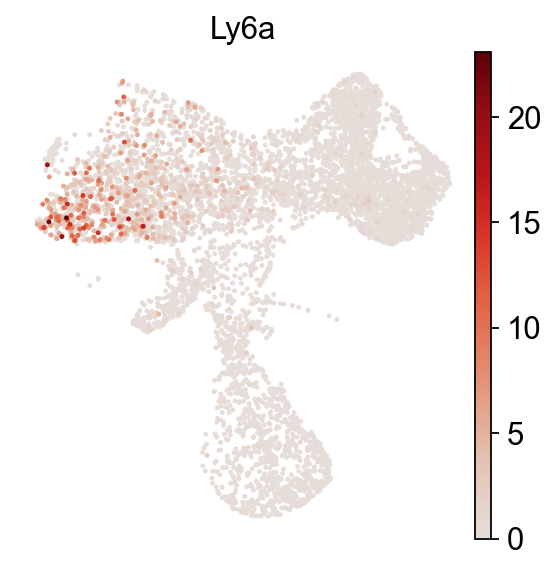

In [9]:
cs.pl.embedding(adata_orig,color='Ly6a',frameon=False)

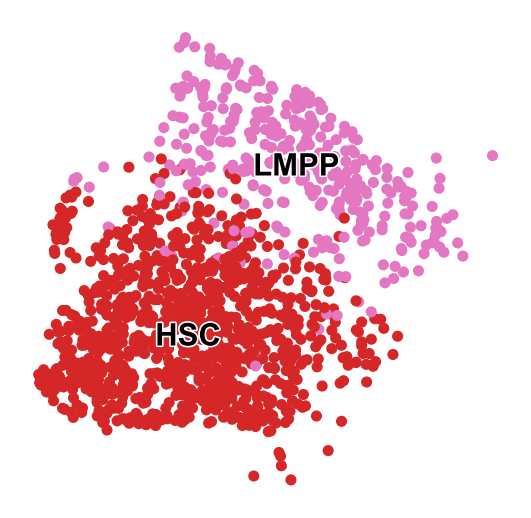

In [10]:
adata_t0=adata_orig[adata_orig.obs['time_info']=='t0']
sc.pl.embedding(adata_t0,color='cell_type',basis='X_umap',legend_loc='on data',
           legend_fontsize=14, legend_fontoutline=1.5,s=100,frameon=False,title='',
               save='_t0_cell_type')

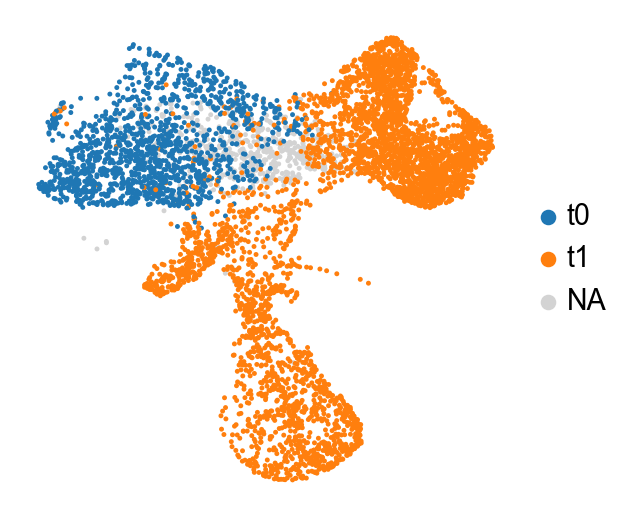

In [11]:
sc.pl.embedding(adata_orig,color='time_info',basis='X_umap',frameon=False,title='',
               save='_time_info')

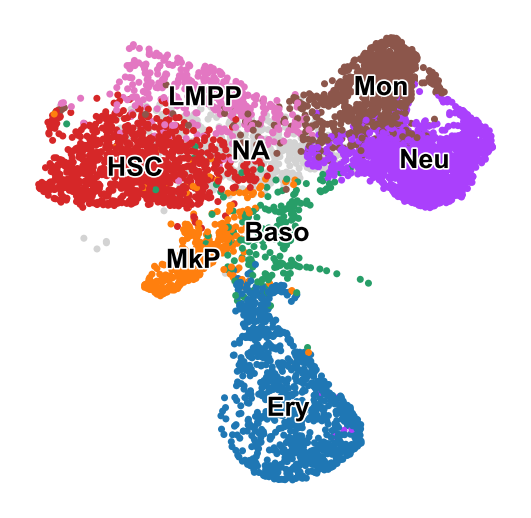

In [12]:
sc.pl.embedding(adata_orig,color='cell_type',basis='X_umap',frameon=False,title='',legend_loc='on data',
           legend_fontsize=12, legend_fontoutline=1.5,s=40,
               save='_skull_celltypes')

## Basic clone statistics

In [13]:
df_clone=cs.tl.clone_statistics(adata_orig,joint_variable='state_info');

In [14]:
cs.tl.add_clone_id_for_each_cell(adata_orig)

In [15]:
np.sum((adata_orig.obsm['X_clone'].sum(0)>0).A.flatten())

1034

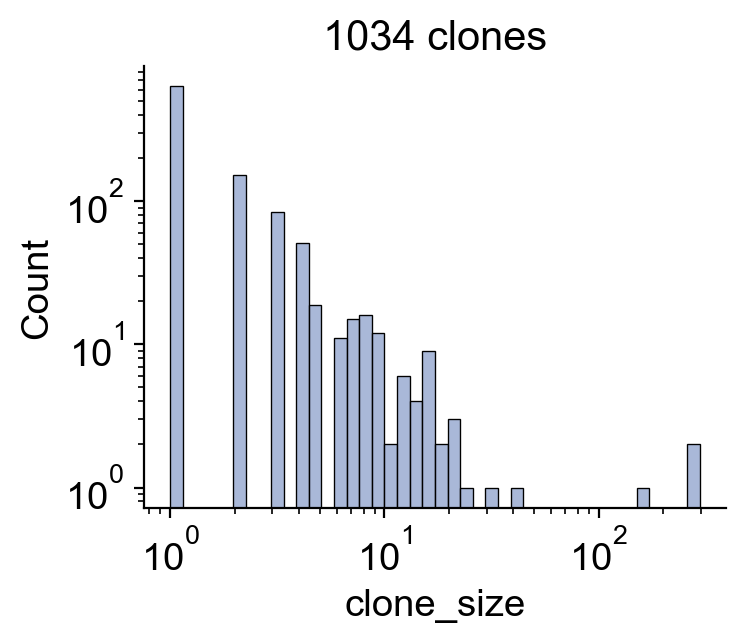

In [28]:
fig,ax=plt.subplots(figsize=(4,3.5))
sns.histplot(df_clone['clone_size'],log_scale=True,color='#8da0cb')
plt.yscale('log')
plt.title(f'{len(df_clone)} clones')
plt.tight_layout()
plt.savefig(f'{figure_path}/skull_clone_distribution.pdf')

In [29]:
df_cell_N=pd.DataFrame(adata_orig.obs['cell_type']).reset_index().groupby('cell_type').agg(count=('index','count')).reset_index()

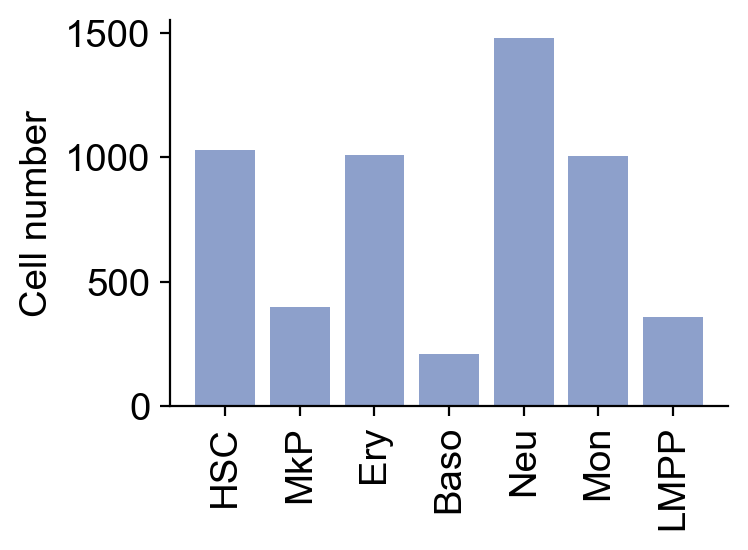

In [30]:
rcParams["axes.grid"] = False
fig,ax=plt.subplots(figsize=(4,3))
plt.bar(df_cell_N['cell_type'],df_cell_N['count'],color='#8da0cb')
#ax=sns.barplot(data=df_clone,x='state',y='clone_N',color=dict(zip(df_clone['state'],df_clone['color']))) #['black', 'red', 'green', 'blue', 'cyan'])
plt.xticks(rotation=90)
plt.ylabel('Cell number')
plt.tight_layout()
plt.savefig(f'{figure_path}/Skull_clone_number_per_cluster.pdf')

<AxesSubplot:xlabel='clone_size', ylabel='Count'>

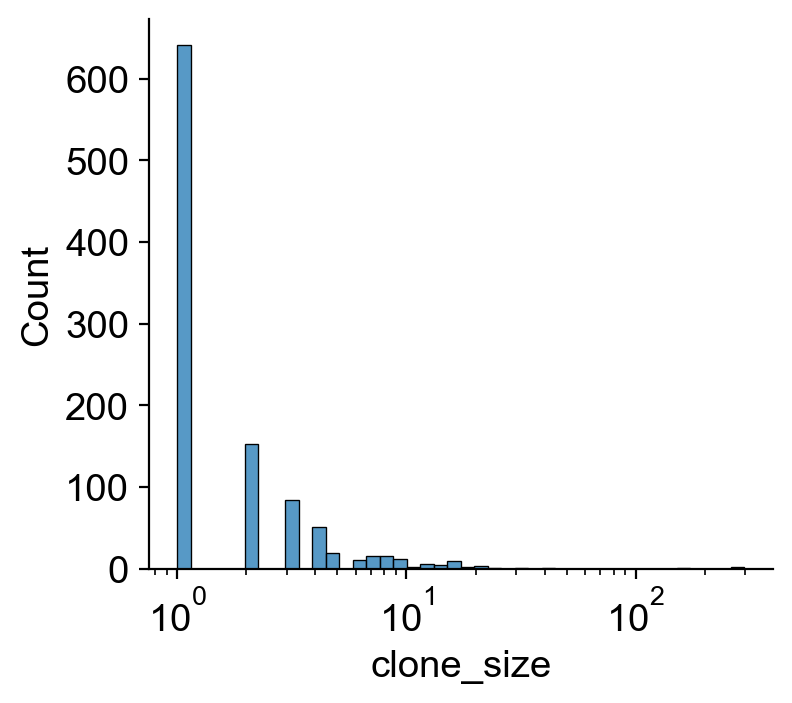

In [31]:
sns.histplot(df_clone['clone_size'],log_scale=True)
#plt.yscale('log')

## Clone output

In [32]:
all_clones_N=np.sum(adata_orig.obsm['X_clone'].A.sum(0)>0)

All clones (regardless of clone size)

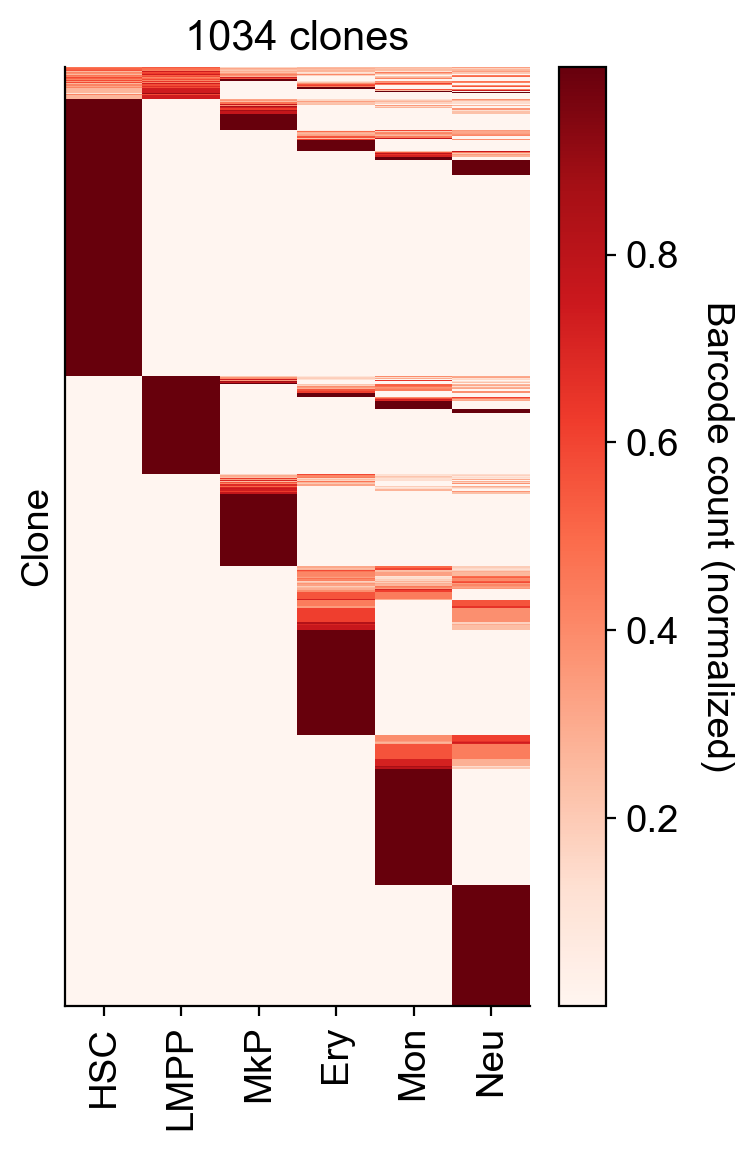

In [33]:
rcParams["axes.grid"] = False
selected_fates=['HSC',  'LMPP','MkP','Ery','Mon',  'Neu', ]
cs.pl.barcode_heatmap(adata_orig,selected_fates=selected_fates,normalize=True)
plt.ylabel('Clone')
plt.title(f'{all_clones_N} clones')
plt.tight_layout()
plt.savefig(f'{figure_path}/all_clone_heatmap.pdf')

only select clones with at least 1 cells

In [34]:
del adata_orig.uns['clone_id']
cs.tl.filter_clones(adata_orig, clone_size_threshold=2, filter_larger_clones=False)
clones_N_2cells=np.sum(adata_orig.obsm['X_clone'].A.sum(0)>0)

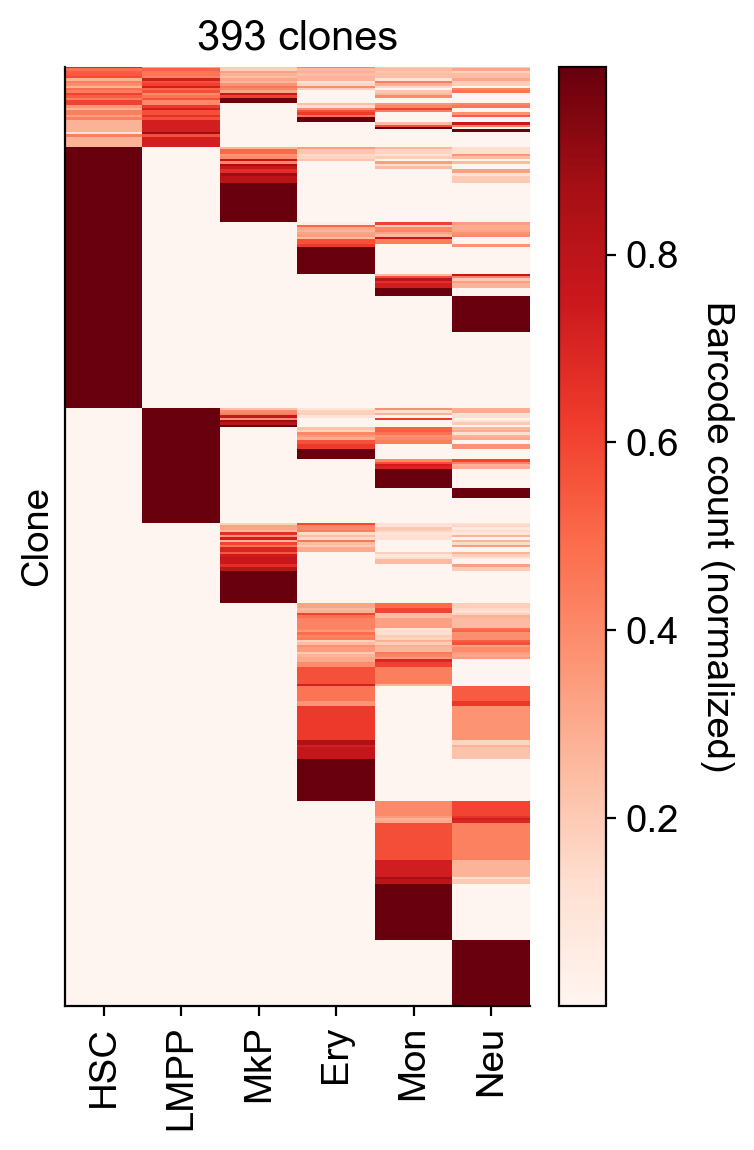

In [35]:
selected_fates=['HSC',  'LMPP','MkP','Ery','Mon',  'Neu', ]
cs.pl.barcode_heatmap(adata_orig,selected_fates=selected_fates,normalize=True)
plt.ylabel('Clone')
plt.title(f'{clones_N_2cells} clones')
plt.tight_layout()
plt.savefig(f'{figure_path}/all_clone_heatmap_>1.pdf')

## Select clones that label both HSC and LMPP

Select clones labeling only HSC

/Users/shouwen/Documents/packages/cospar/cospar/tool/_clone.py:869: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_orig = sc.AnnData(X_clone)


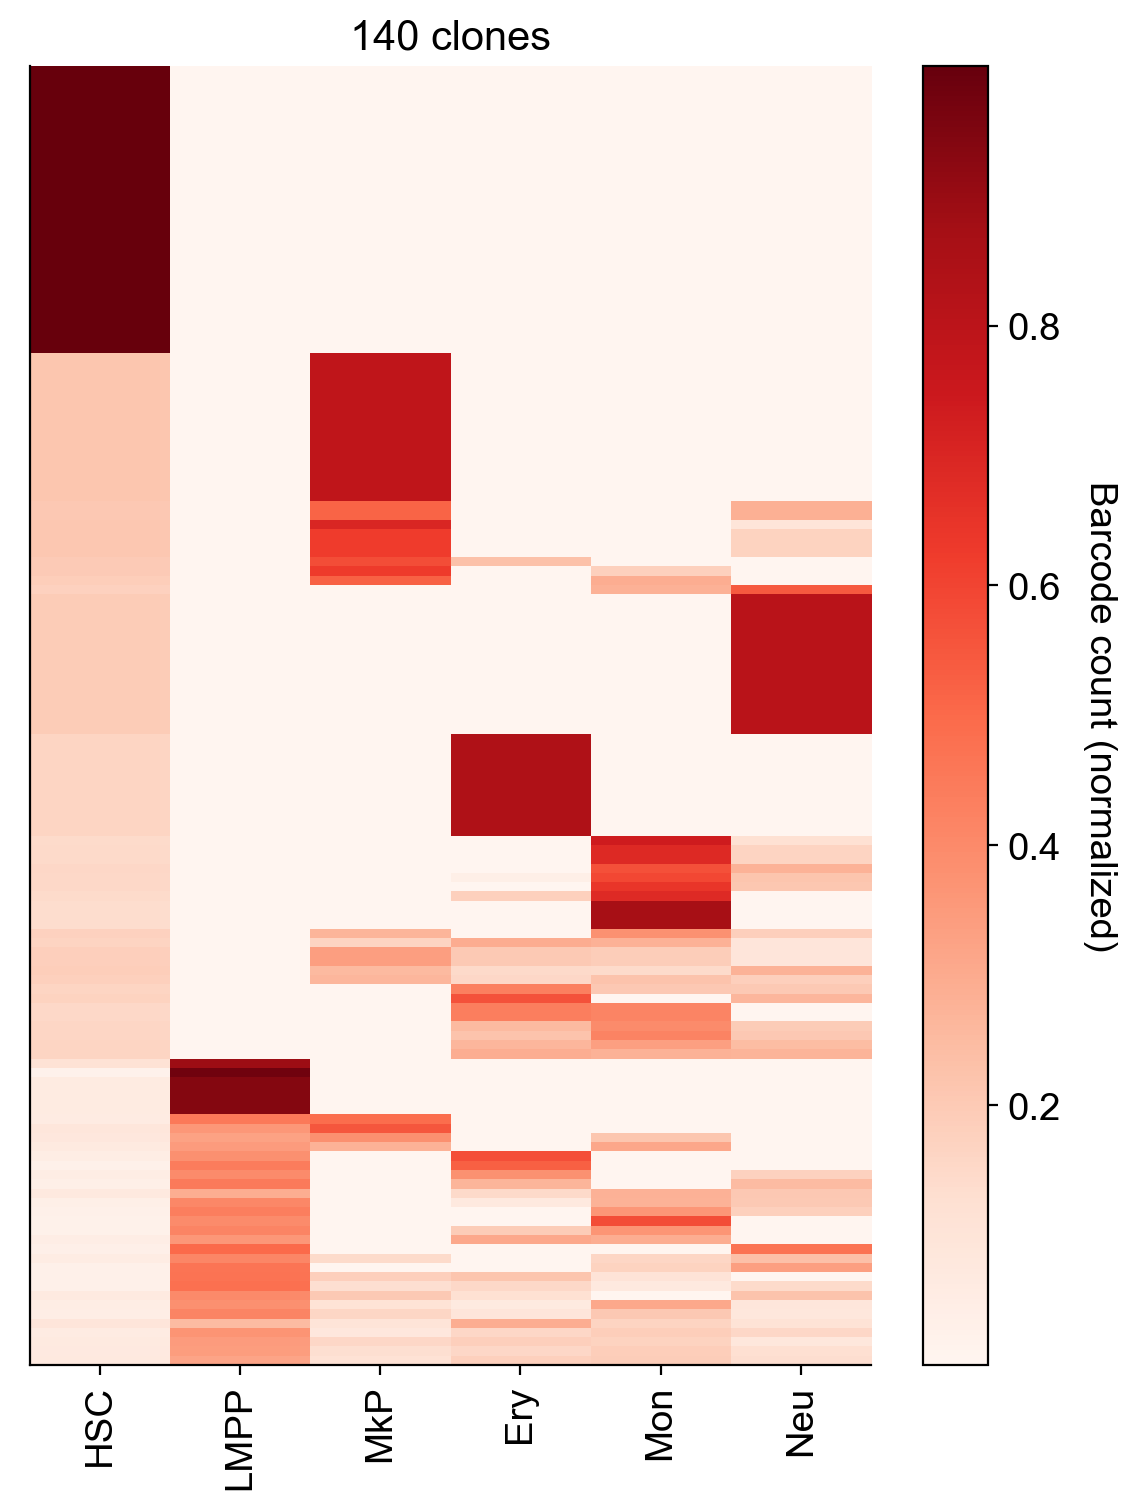

In [36]:
restricted_X_clone_HSC=cs.tl.conditional_heatmap(adata_orig.uns['barcode_heatmap']['coarse_X_clone'],
                                          adata_orig.uns['barcode_heatmap']['fate_names'],
                                          included_fates=['HSC'],normalize=True,mode='or')

Select clones labeling only LMPP

/Users/shouwen/Documents/packages/cospar/cospar/tool/_clone.py:869: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_orig = sc.AnnData(X_clone)


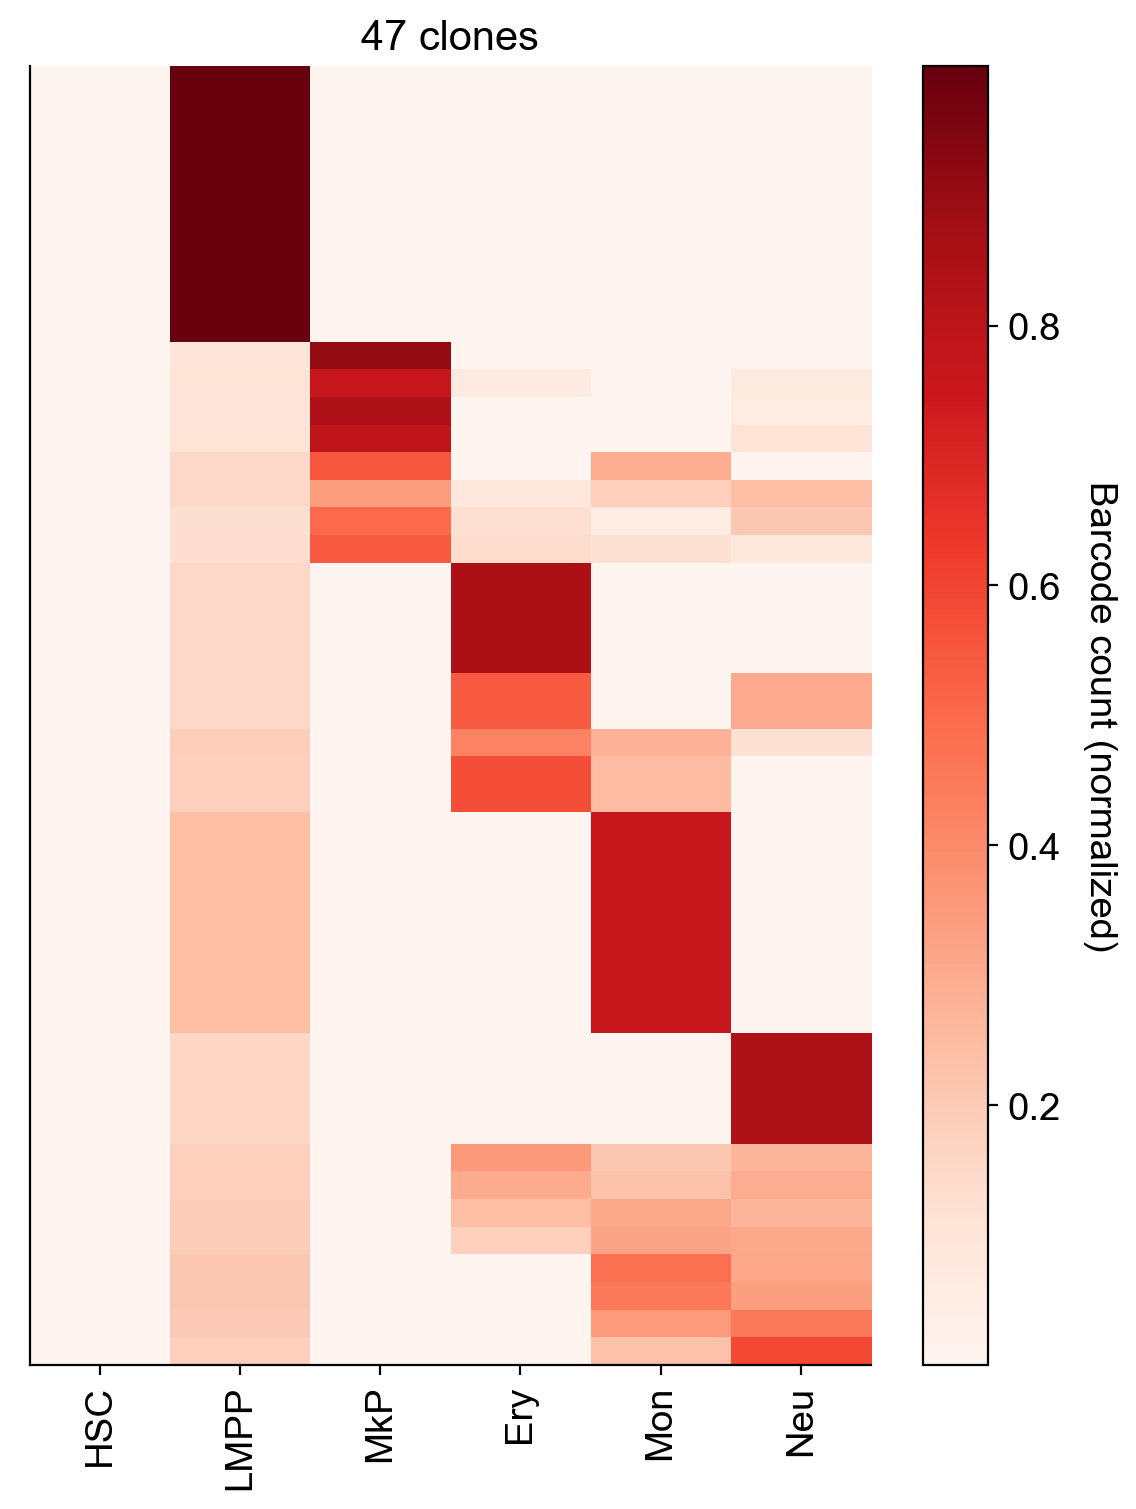

In [37]:
plt.rcParams["figure.figsize"]=(4,4)
restricted_X_clone_LMPP=cs.tl.conditional_heatmap(adata_orig.uns['barcode_heatmap']['coarse_X_clone'],
                                          adata_orig.uns['barcode_heatmap']['fate_names'],
                                          included_fates=['LMPP'],excluded_fates=['HSC'],normalize=True,mode='and')

Order these clones

In [38]:
restricted_X_clone_HSC_new=cs.pl.custom_hierachical_ordering(
        np.arange(restricted_X_clone_HSC.shape[0]), restricted_X_clone_HSC
    )

restricted_X_clone_LMPP_new=cs.pl.custom_hierachical_ordering(
        np.arange(restricted_X_clone_LMPP.shape[0]), restricted_X_clone_LMPP
    )

In [39]:
tot_clone_N_HSC_LMPP=np.hstack([restricted_X_clone_HSC_new,restricted_X_clone_LMPP_new]).T.shape[0]
print(tot_clone_N_HSC_LMPP,'clones')

187 clones


concatenate these clones

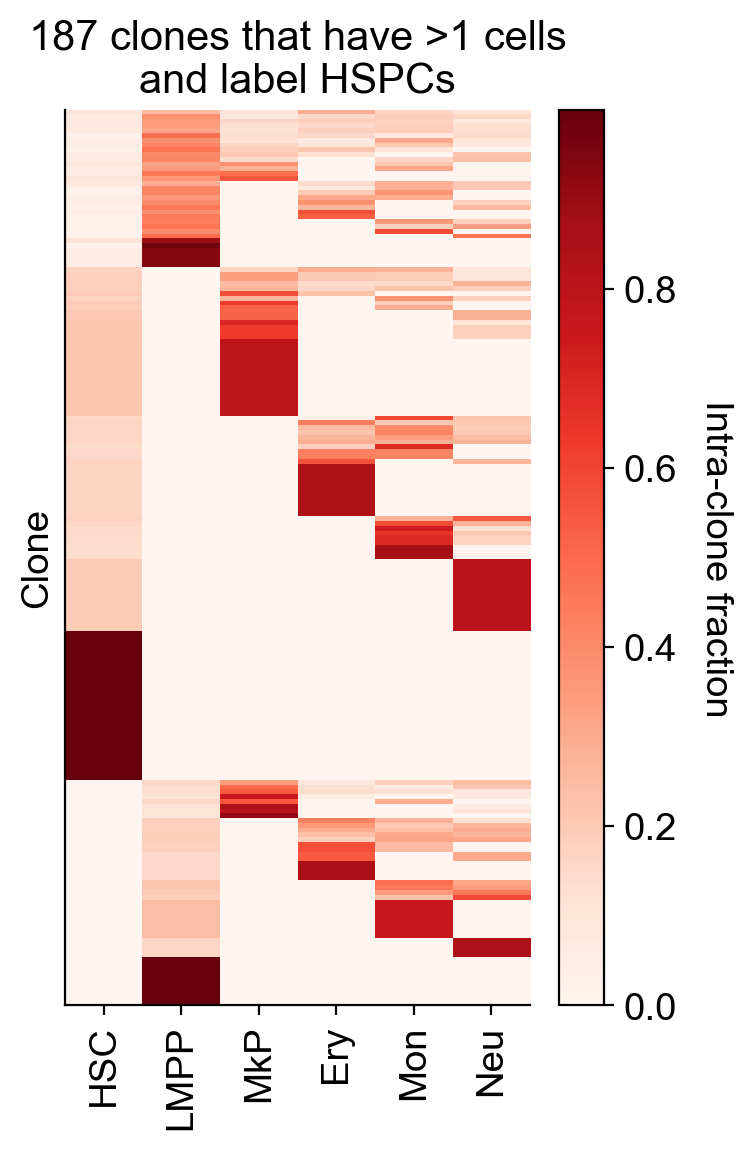

In [40]:
cs.pl.heatmap(np.hstack([restricted_X_clone_HSC_new,restricted_X_clone_LMPP_new]).T,order_map_x=False,order_map_y=False,
             x_ticks=adata_orig.uns['barcode_heatmap']['fate_names'],color_bar_label='Intra-clone fraction')
plt.ylabel('Clone')
plt.title(f'{tot_clone_N_HSC_LMPP} clones that have >1 cells\nand label HSPCs')
plt.tight_layout()
plt.savefig(f'{figure_path}/Skull_HSC_output.pdf')

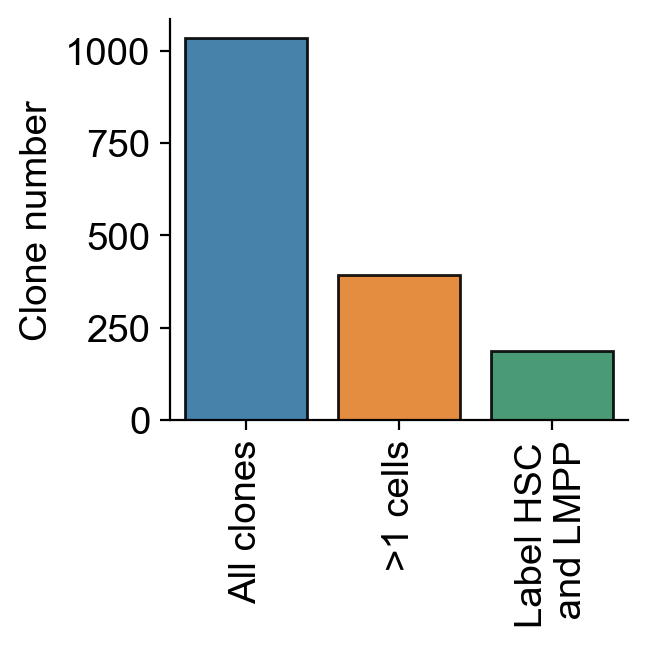

In [41]:
fig,ax=plt.subplots(figsize=(3.5,3.5))
kwargs = {'alpha':0.9, 'linewidth':1, 'edgecolor':'k'}
ax=sns.barplot(x=[1,2,3],y=[all_clones_N,clones_N_2cells,tot_clone_N_HSC_LMPP],**kwargs)
ax.set_xticks([0,1,2], ['All clones','>1 cells','Label HSC\n and LMPP'], #['All clones', 'Clones with \n >1 cells', 'Clones with \n HSPCs \n and >1 cells'],
       rotation=90)  # Set text labels and properties.
ax.set_ylabel('Clone number')
plt.tight_layout()
plt.savefig(f'{figure_path}/clone_number_breakdown.pdf')

In [42]:
X0=np.hstack([restricted_X_clone_HSC_new,restricted_X_clone_LMPP_new]).T[:,2:]
X1=X0[X0.sum(1)>0] # only select clones with both state and fate outcomes
frac=np.sum((X1/(X1.sum(1)[:,np.newaxis]+10**(-10)))>0.99,axis=1).mean()
print(f'{100*frac:.2f}% of {len(X1)} clones ({X1[0]}) labling early progenitor have a single fate outcome')

48.57% of 140 clones ([0.09811269 0.28963016 0.16509398 0.10756418]) labling early progenitor have a single fate outcome


## Clonal coupling between cell types and their p-values

In [43]:
adata_output,X_coupling_random=cs.tl.pvalue_for_fate_coupling(adata_orig,selected_fates=selected_fates,max_N_simutation=10000,normalize=True)

/Users/shouwen/Documents/packages/cospar/cospar/tool/_map.py:371: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["time_info"] = pd.Categorical(adata.obs["time_info"].astype(str))
/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
100%|█████████████████████████████████████| 10000/10000 [02:07<00:00, 78.72it/s]


<AxesSubplot:ylabel='Count'>

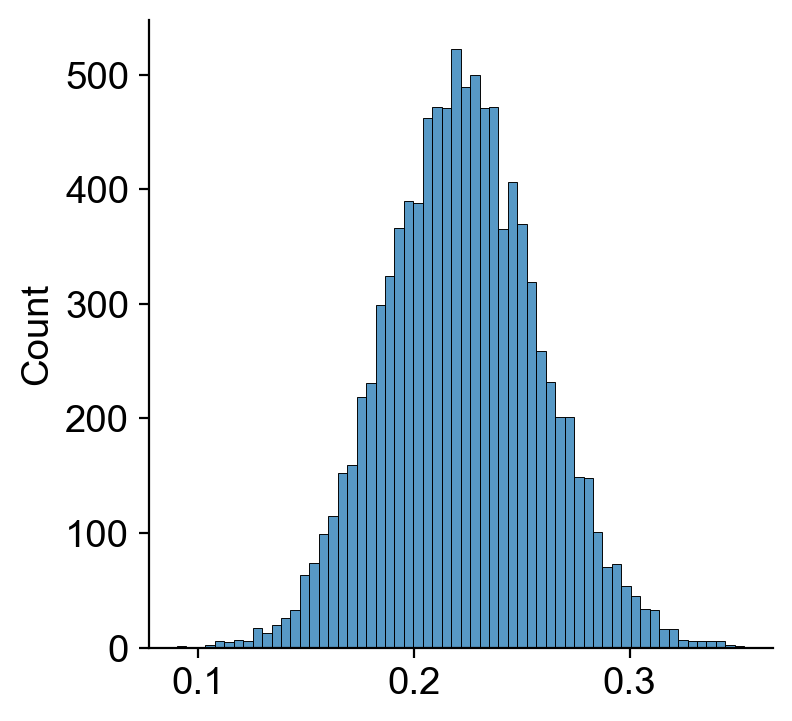

In [44]:
sns.histplot(X_coupling_random[:,0,2])

In [45]:
X_coupling=adata_output.uns['fate_coupling_X_clone']['X_coupling']
fate_names=adata_output.uns['fate_coupling_X_clone']['fate_names']
pvalue=adata_output.uns['fate_coupling_X_clone']['pvalue']
pvalue_greater=adata_output.uns['fate_coupling_X_clone']['pvalue_greater']
pvalue_less=adata_output.uns['fate_coupling_X_clone']['pvalue_less']

The coupling matrix has been computed, and can be visualized directly

<AxesSubplot:>

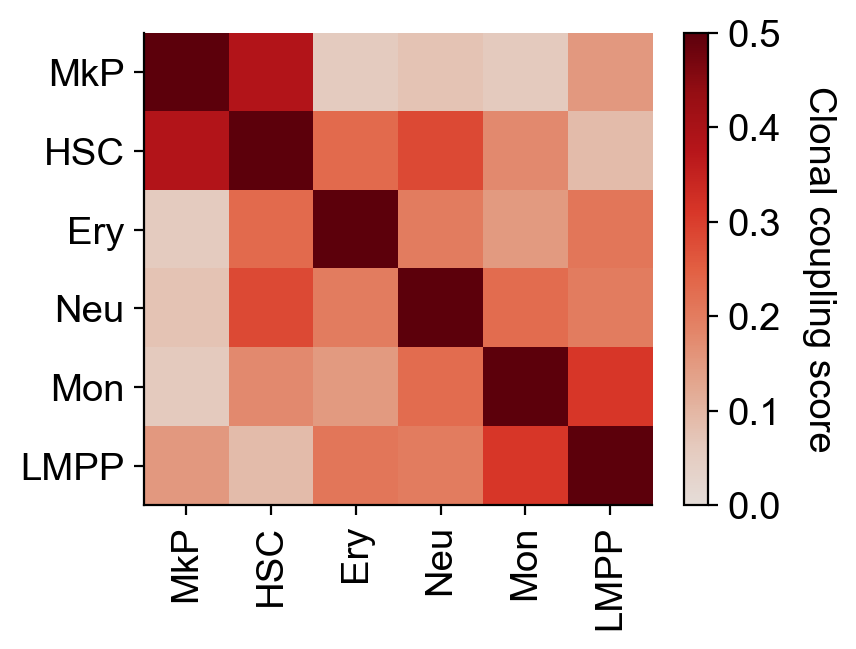

In [46]:
cs.pl.fate_coupling(adata_output, source="X_clone",vmax=0.5,vmin=0,title='',figure_index='clonal_coupling')  # actually plot the coupling

In [47]:
new_fate_names=['MkP','HSC','Ery','Neu','Mon','LMPP']
sp_id=[]
for x in new_fate_names:
    sp_id.append(np.nonzero(fate_names==x)[0][0])
    
ordered_pvalue_greater=pvalue_greater[sp_id][:,sp_id]
ordered_pvalue_greater=np.nan_to_num(ordered_pvalue_greater,nan=1)

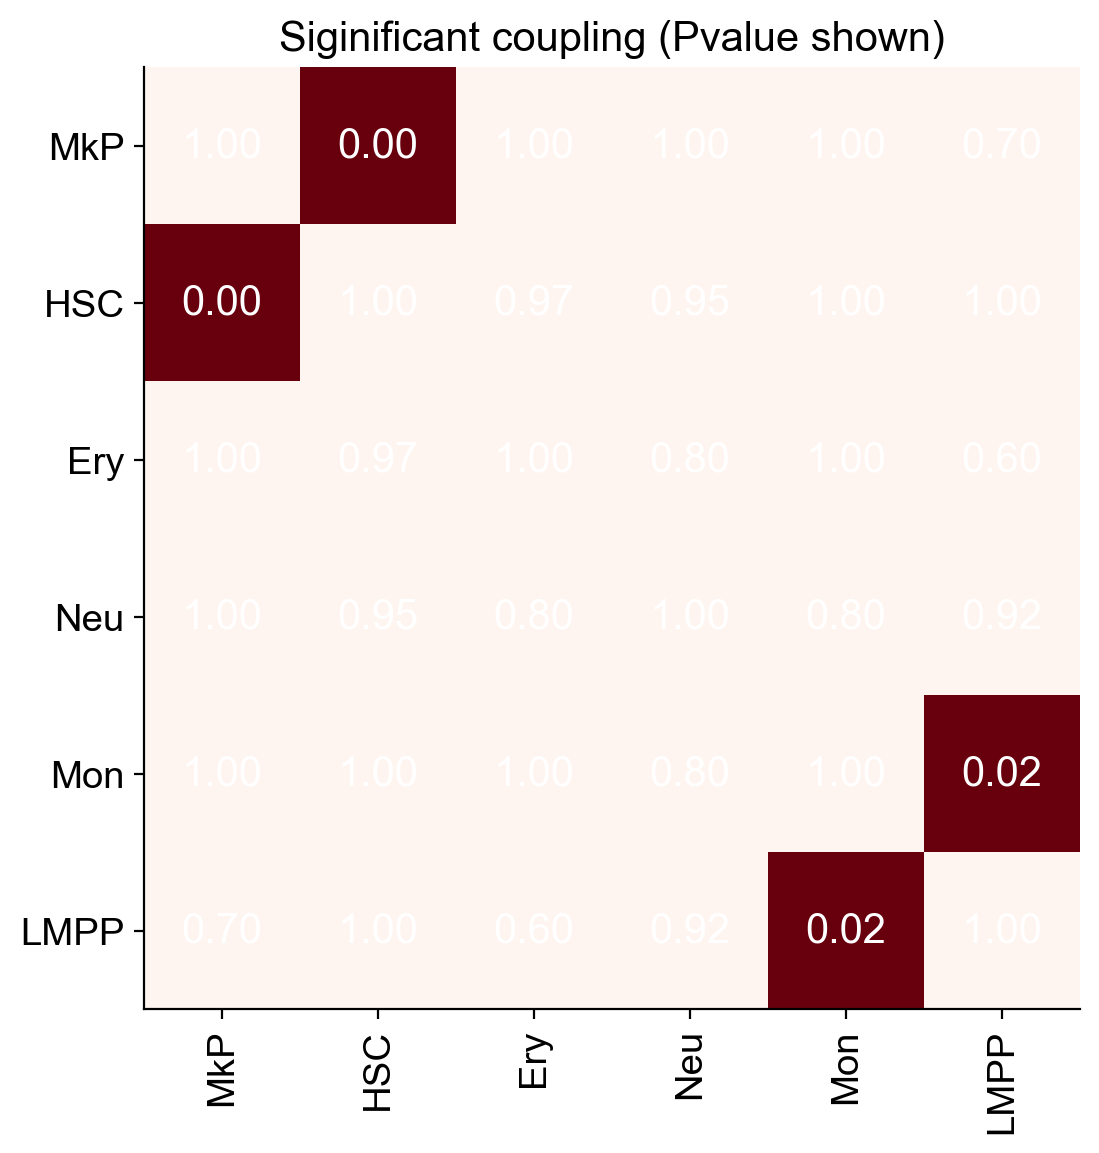

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for the heatmap
data = np.random.rand(5, 5)

# Create a heatmap
ax=cs.pl.heatmap((ordered_pvalue_greater<0.05).astype(float),
              order_map_x=False,order_map_y=False,fig_width=6,color_bar=False,
              x_ticks=new_fate_names,y_ticks=new_fate_names)

# Add text annotations to the heatmap cells
for i in range(ordered_pvalue_greater.shape[0]):
    for j in range(ordered_pvalue_greater.shape[1]):
        plt.text(j, i, f'{ordered_pvalue_greater[i, j]:.2f}', ha='center', va='center', color='white')
        
ax.set_title('Siginificant coupling (Pvalue shown)')
plt.show()

In [49]:
cs.tl.fate_hierarchy(
    adata_orig, selected_fates=selected_fates, source="X_clone"
)  # compute the fate hierarchy
cs.pl.fate_hierarchy(adata_orig, source="X_clone")  # actually plot the hierarchy


         /-Mon
      /-|
     |   \-LMPP
   /-|
  |  |      /-MkP
  |  |   /-|
--|   \-|   \-HSC
  |     |
  |      \-Neu
  |
   \-Ery


## Progenitors with the same observed clonal fate bias

In [50]:
df_clone=cs.tl.clone_statistics(adata_orig,joint_variable='state_info');

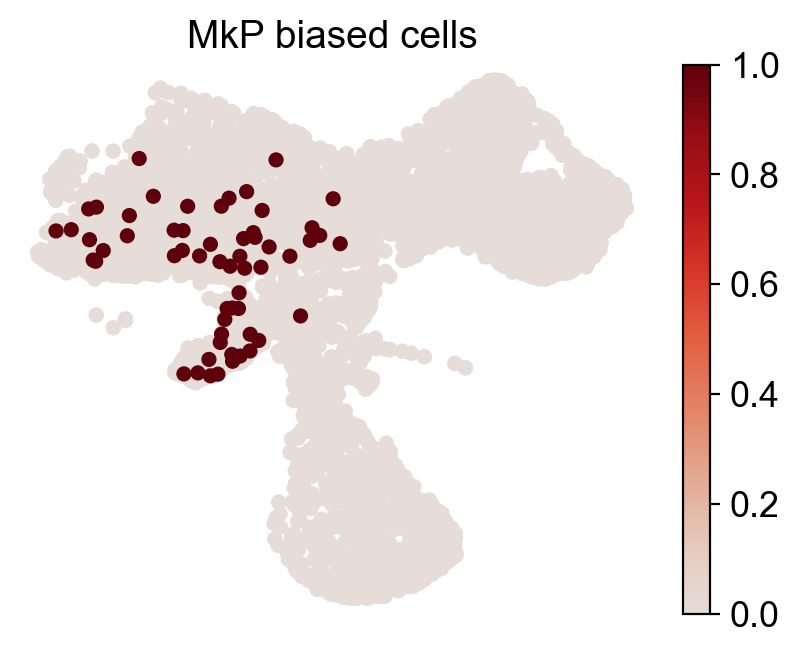

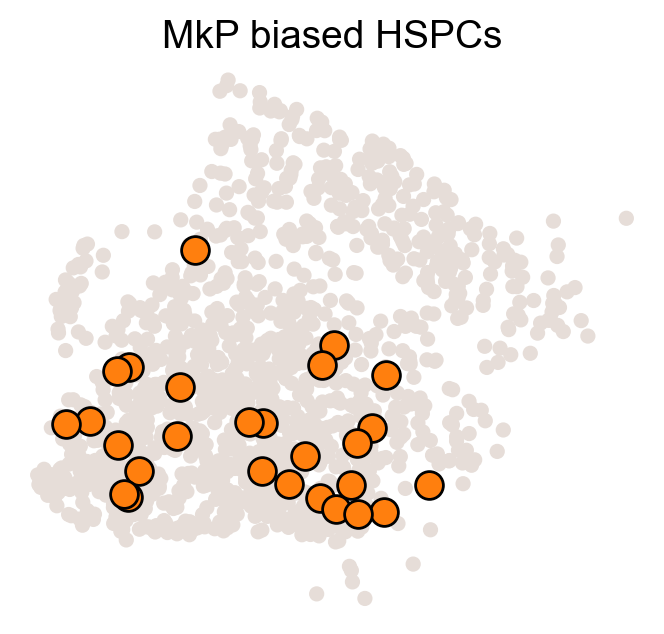

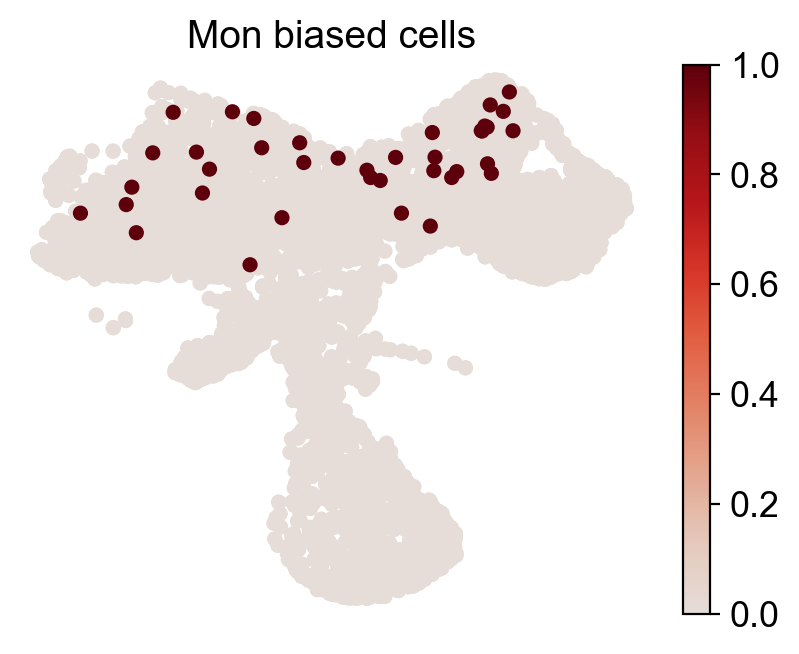

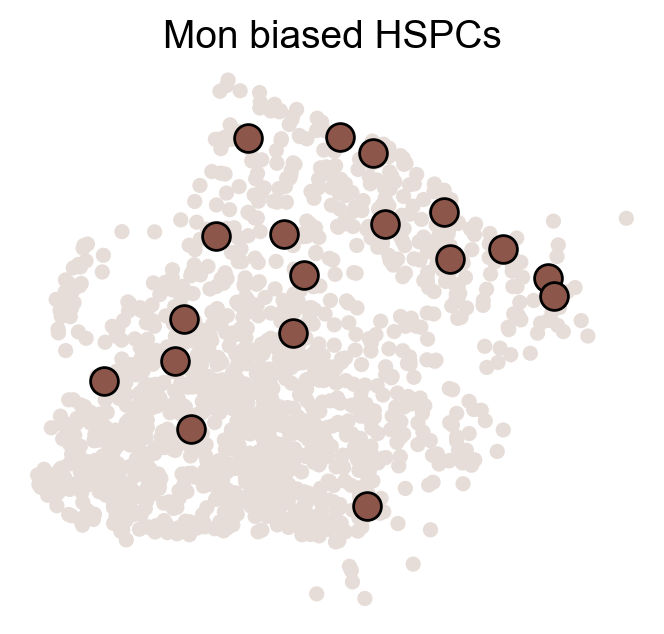

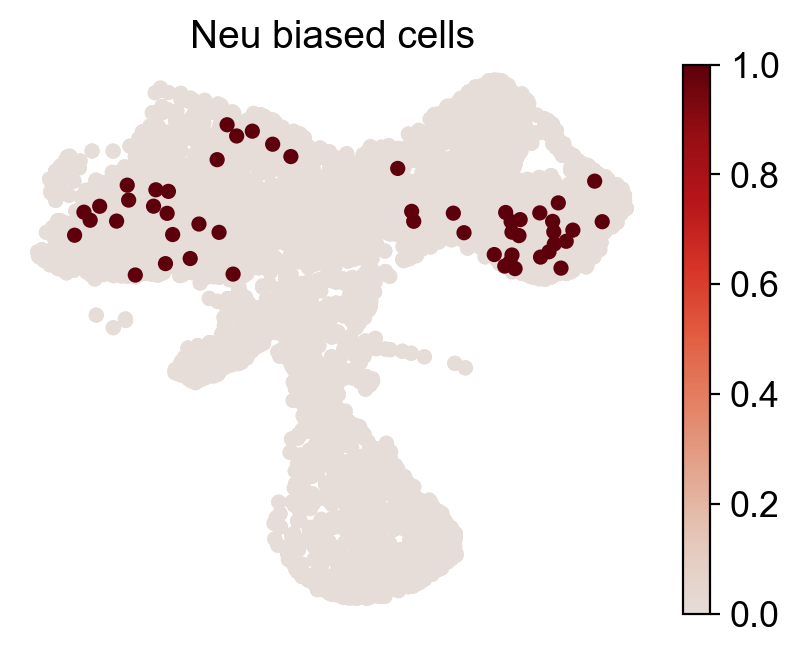

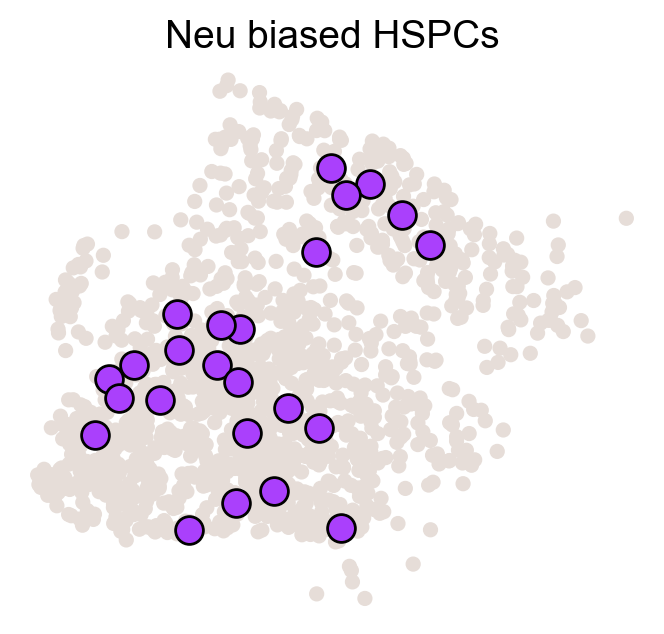

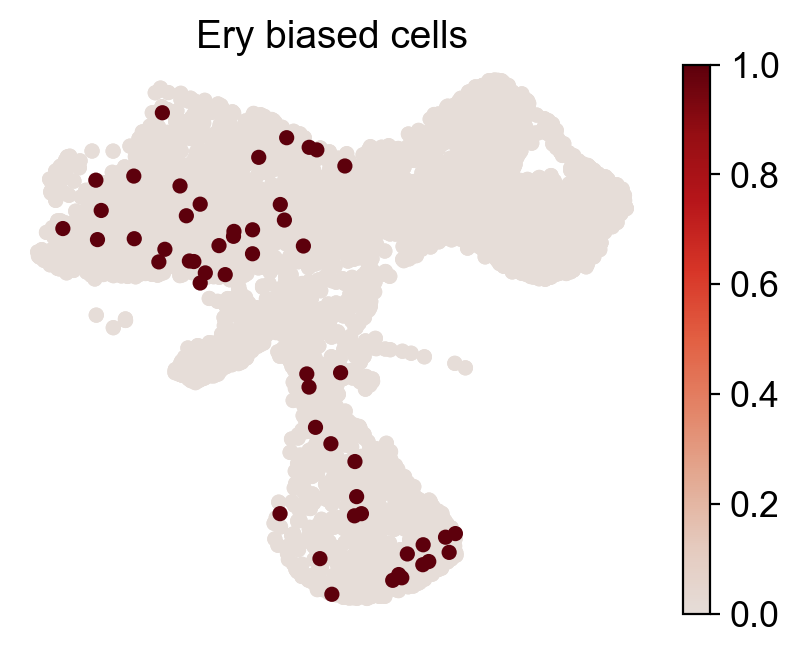

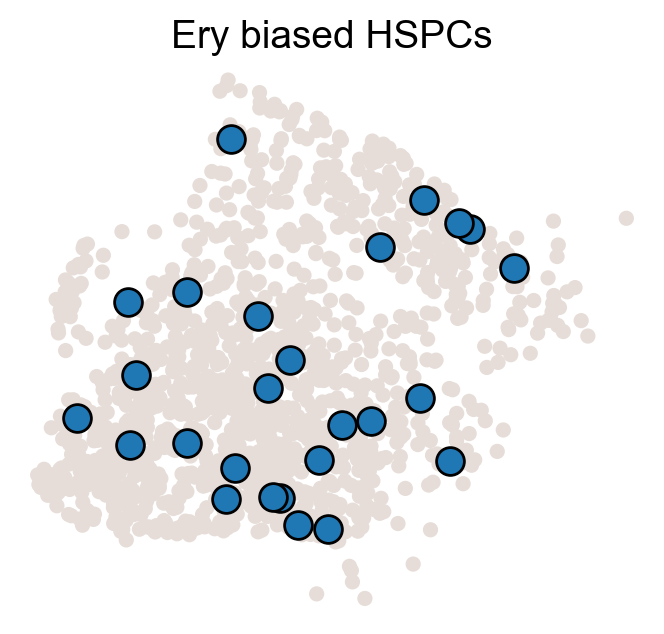

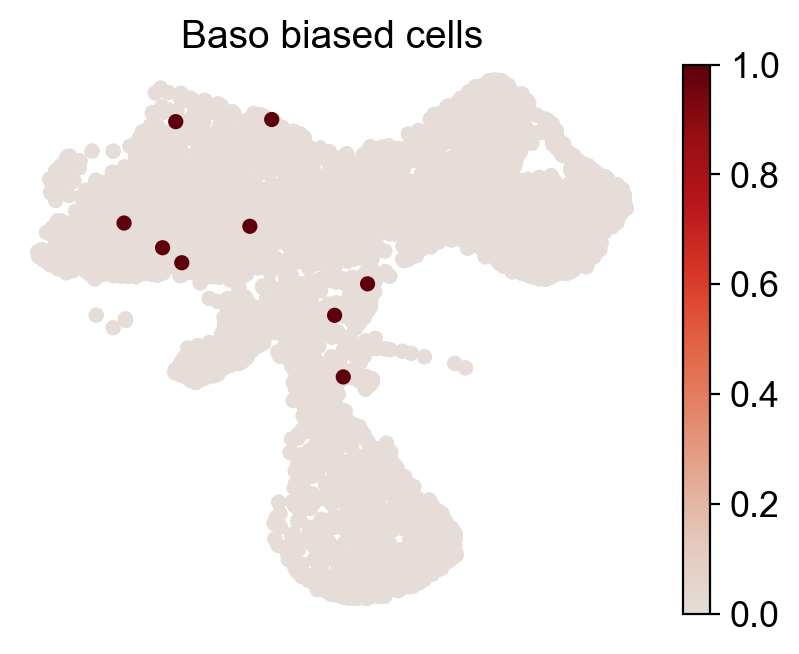

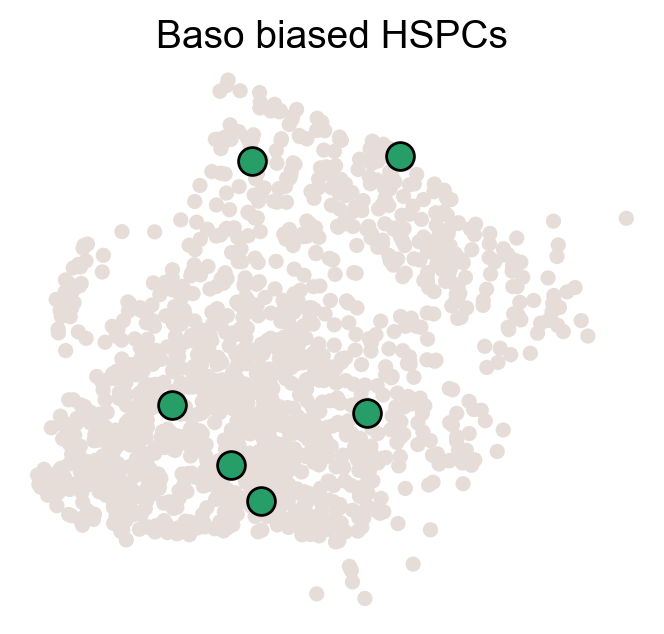

In [51]:
ref_fates=['MkP','Mon','Neu','Ery','Baso']
cs.settings.set_figure_params(pointsize=20)
df_clone['state_info']=df_clone['state_info'].str.split(',').apply(lambda x: sorted(x)).apply(lambda x:','.join(x))
celltype_colors=dict(zip(adata_orig.obs['cell_type'].cat.categories,adata_orig.uns['cell_type_colors']))
for fate_tmp in ref_fates:
    all_fates_tmp=ref_fates.copy()
    all_fates_tmp.remove(fate_tmp)
    df_clone_sub=df_clone[df_clone['state_info'].apply(lambda x: (fate_tmp in x) & (('HSC' in x)  or ('LMPP' in x)) & (np.sum([__ in x for __ in all_fates_tmp])==0) )]


    MkP_bias=(adata_orig.obsm['X_clone'][:,df_clone_sub['clone_id'].to_numpy()].sum(1).A.flatten()>0).astype(int)
    cell_id_t1=np.ones(len(MkP_bias)).astype(bool)
    sp_idx=np.arange(np.sum(cell_id_t1))

    cs.pl.fate_map_embedding(adata_orig,MkP_bias,cell_id_t1=cell_id_t1,sp_idx=sp_idx,
                            figure_title=f'{fate_tmp} biased cells')
    
    
    color_tmp=celltype_colors[fate_tmp]
    adata_tmp=adata_orig.copy()
    adata_tmp.uns['data_des']=['all_bias_clones']
    adata_tmp.obsm['X_clone']=ssp.csr_matrix(np.array([(MkP_bias>0).astype(int)])).T
    ax=cs.pl.clones_on_manifold(adata_tmp,selected_clone_list=[0],
                            color_list=[color_tmp,color_tmp,color_tmp],clone_markersize=20,
                            selected_times='t0')
    ax.set_title(f'{fate_tmp} biased HSPCs')
    plt.savefig(f'{cs.settings.figure_path}/all_mkp_bias_clones_different_clones_{fate_tmp}.pdf')
    

## Identify MkP-fate biased clones

100%|███████████████████████████████████████| 393/393 [00:00<00:00, 1565.39it/s]
/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


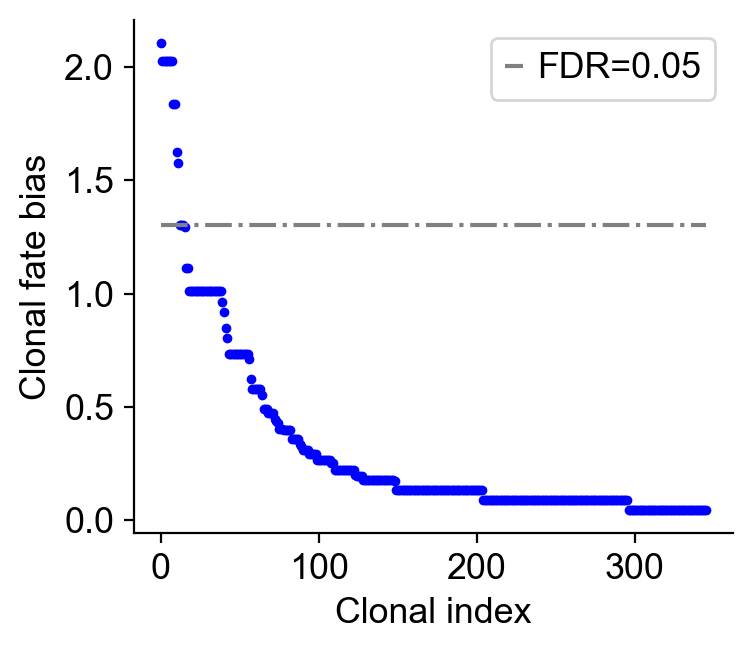

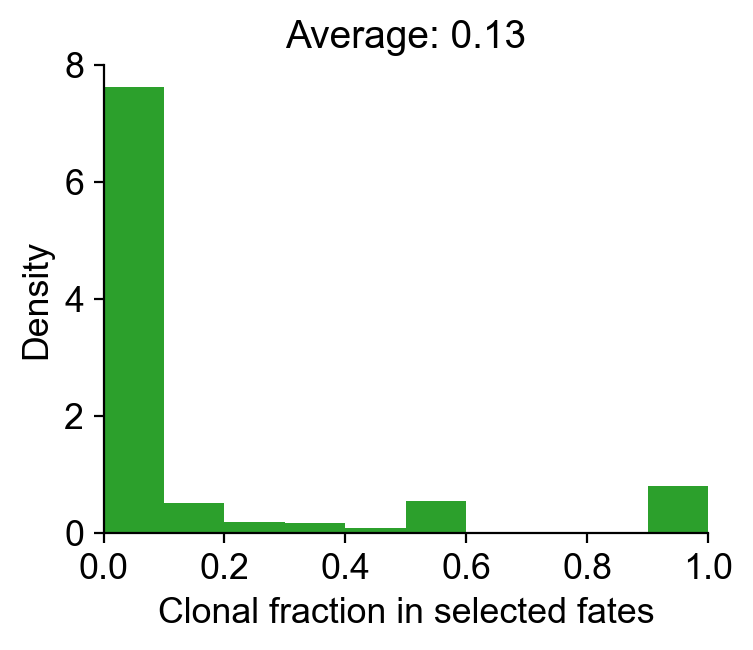

In [52]:
adata_orig_t2=adata_orig[adata_orig.obs['time_info']=='t1']
cs.tl.clonal_fate_bias(
    adata_orig_t2, selected_fate="MkP", alternative="two-sided"
)  
cs.pl.clonal_fate_bias(adata_orig_t2) 
df_pvalue_MkP=adata_orig_t2.uns['clonal_fate_bias']

<AxesSubplot:xlabel='P_value', ylabel='Count'>

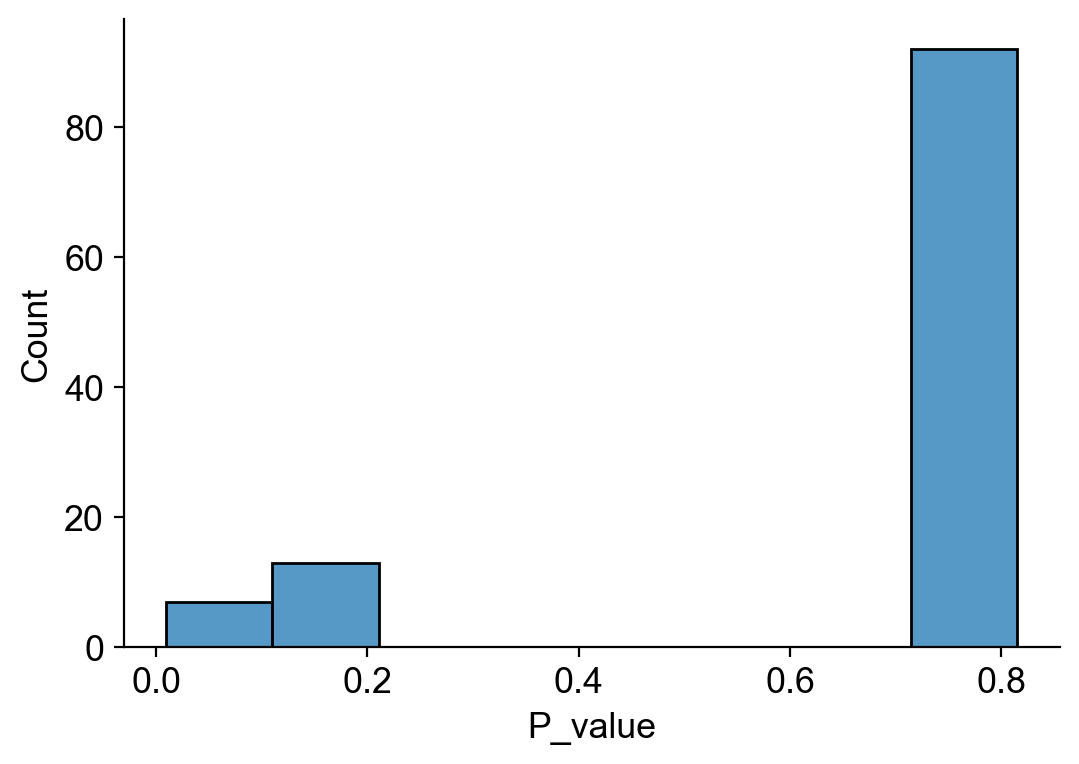

In [53]:
sns.histplot(df_pvalue_MkP[df_pvalue_MkP['clone_size']==2]['P_value'])

In [54]:
df_clone_sub=df_clone[df_clone['state_info'].apply(lambda x: x=='HSC,MkP')]
df_clone_sub=df_clone_sub.merge(df_pvalue_MkP.filter(['clone_id','clonal_fraction_in_target_fate','P_value','clone_size']),on=['clone_id'])
df_clone_sub

clone_id  clone_size_x state_info  state_info_N  \
0         41             2    HSC,MkP             2   
1        104             2    HSC,MkP             2   
2        107             2    HSC,MkP             2   
3        135             2    HSC,MkP             2   
4        163             6    HSC,MkP             2   
5        181             4    HSC,MkP             2   
6        196             2    HSC,MkP             2   
7        198             3    HSC,MkP             2   
8        305             3    HSC,MkP             2   
9        307             2    HSC,MkP             2   
10       318             3    HSC,MkP             2   
11       371             2    HSC,MkP             2   

    clonal_fraction_in_target_fate   P_value  clone_size_y  
0                              1.0  0.097317           1.0  
1                              1.0  0.097317           1.0  
2                              1.0  0.097317           1.0  
3                              1.0  0.097317           1.0  
4                              1.0  0.097317           1.0  
5                              1.0  0.009449           2.0  
6                              1.0  0.097317           1.0  
7                              1.0  0.097317           1.0  
8                              1.0  0.097317           1.0  
9                              1.0  0.097317           1.0  
10                             1.0  0.009449           2.0  
11                             1.0  0.097317           1.0

<AxesSubplot:title={'center':'ID: 318'}>

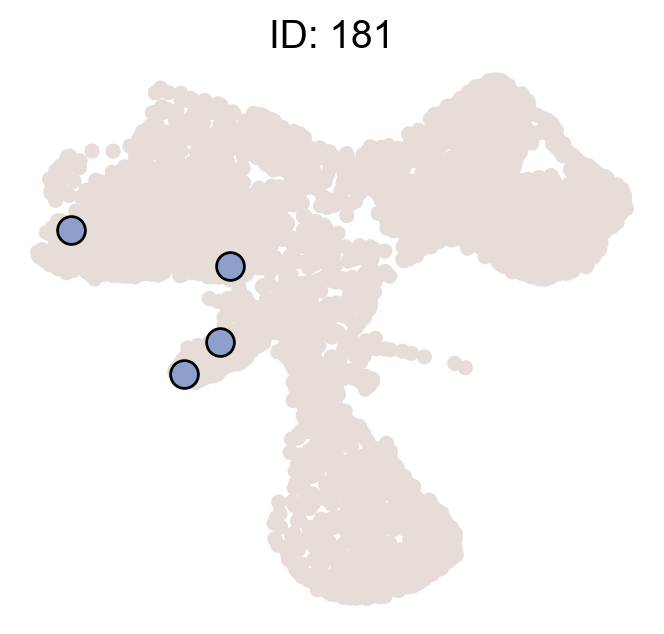

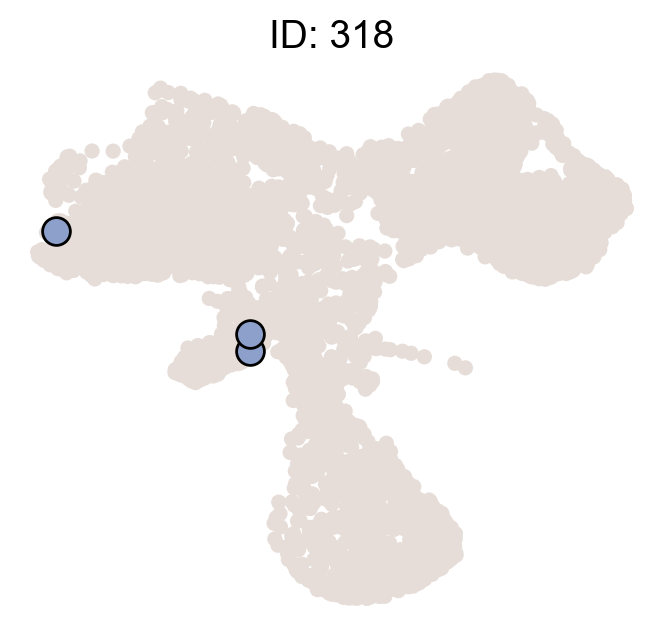

In [55]:
cs.pl.clones_on_manifold(adata_orig,selected_clone_list=df_clone_sub.query('P_value<0.05').clone_id.to_list(),
                        color_list=['#8da0cb','#8da0cb','#8da0cb'],clone_markersize=20)


## CoSpar predicted fate bias

In [56]:
adata = cs.tmap.infer_Tmap_from_multitime_clones(
    adata_orig,
    clonal_time_points=["t0"],
    later_time_point="t1",
    smooth_array=[10,10,5],
    sparsity_threshold=0.1,
    intraclone_threshold=0.2,
    max_iter_N=10,
    epsilon_converge=0.01,
)

/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


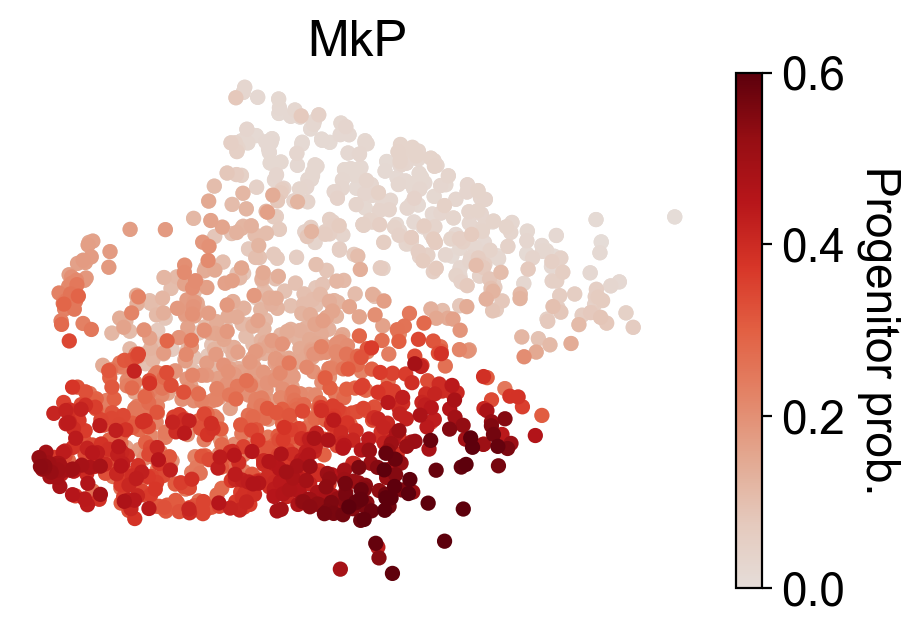

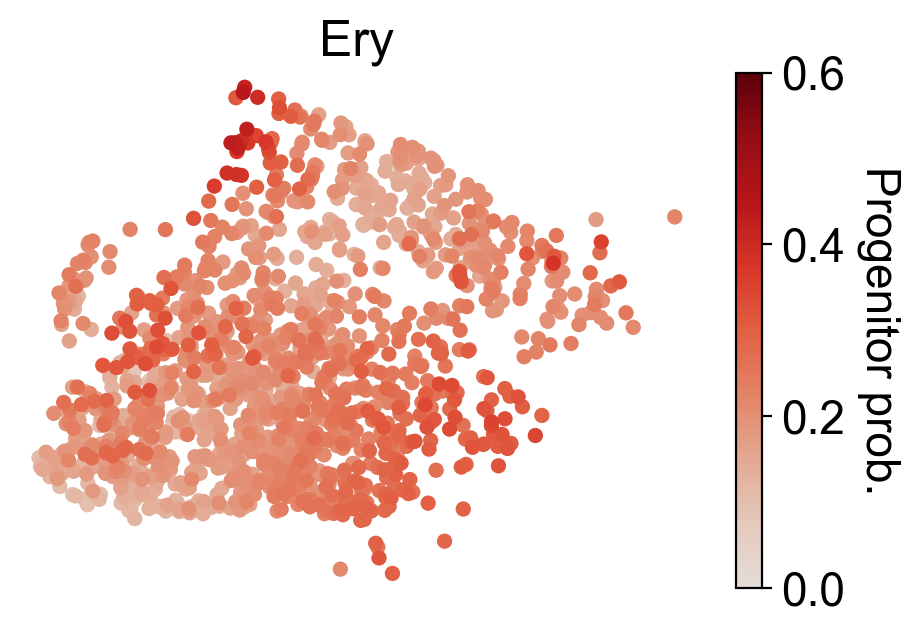

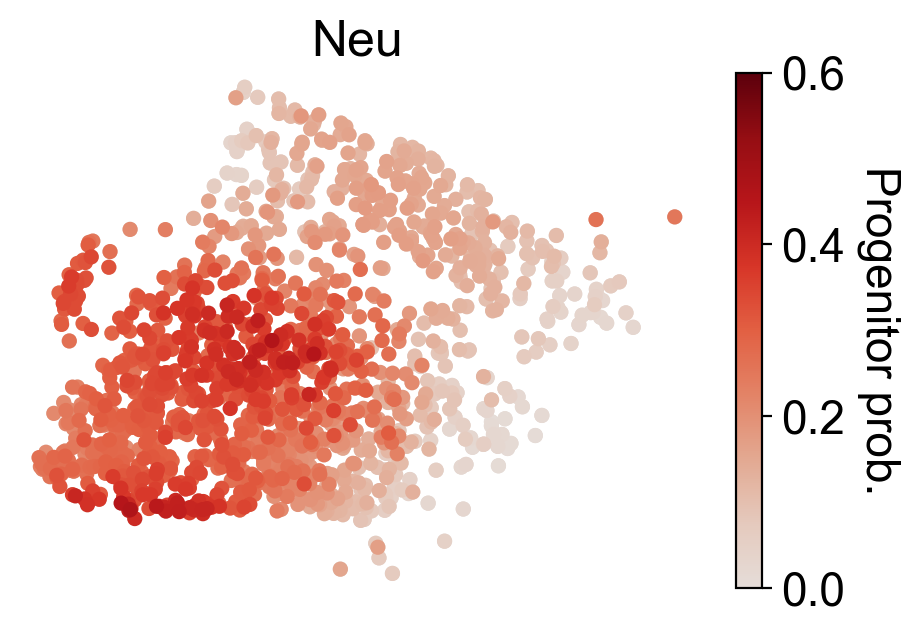

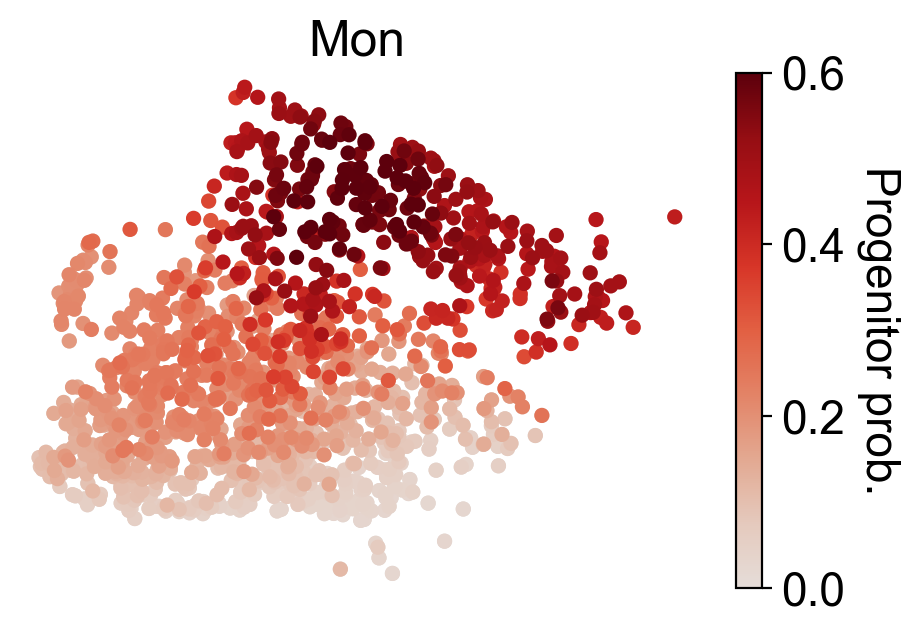

In [57]:
cs.settings.set_figure_params(pointsize=20,fontsize=18)
for selected_fates in [['MkP'],['Ery'],['Neu'],['Mon']]:
    cs.tl.fate_map(
        adata,
        selected_fates=selected_fates,
        source="transition_map",
        map_backward=True,
    )
    cs.pl.fate_map(
        adata,
        selected_fates=selected_fates,
        selected_times='t0',
        source="transition_map",
        plot_target_state=False,
        background=False,
        show_histogram=False,
        auto_color_scale=False,
        vmax=0.6,
        
    )

## Differential gene analysis

In [58]:
adata.obs['Fate_bias']=np.nan
sel_idx_1=((adata.obs['fate_map_transition_map_MkP']>0.25) & (adata.obsm['X_emb'][:,0]<4))
adata.obs.loc[sel_idx_1,'Fate_bias']='Early MkP bias'
sel_idx_2=((adata.obs['fate_map_transition_map_MkP']>0.25) & (adata.obsm['X_emb'][:,0]>=4))
adata.obs.loc[sel_idx_2,'Fate_bias']='Late MkP bias'
#sel_idx_3=((adata.obs['fate_map_transition_map_MkP']<=0.25)) & (adata.obs['time_info']=='t0')
sel_idx_3=((adata.obs['fate_map_transition_map_MkP']<=0.25)) & (adata.obs['state_info']=='HSC')
adata.obs.loc[sel_idx_3,'Fate_bias']='No MkP bias'
sel_idx_4=(adata.obs['state_info']=='LMPP')
adata.obs.loc[sel_idx_4,'Fate_bias']='LMPP'
adata_sub=adata[adata.obs['time_info']=='t0']

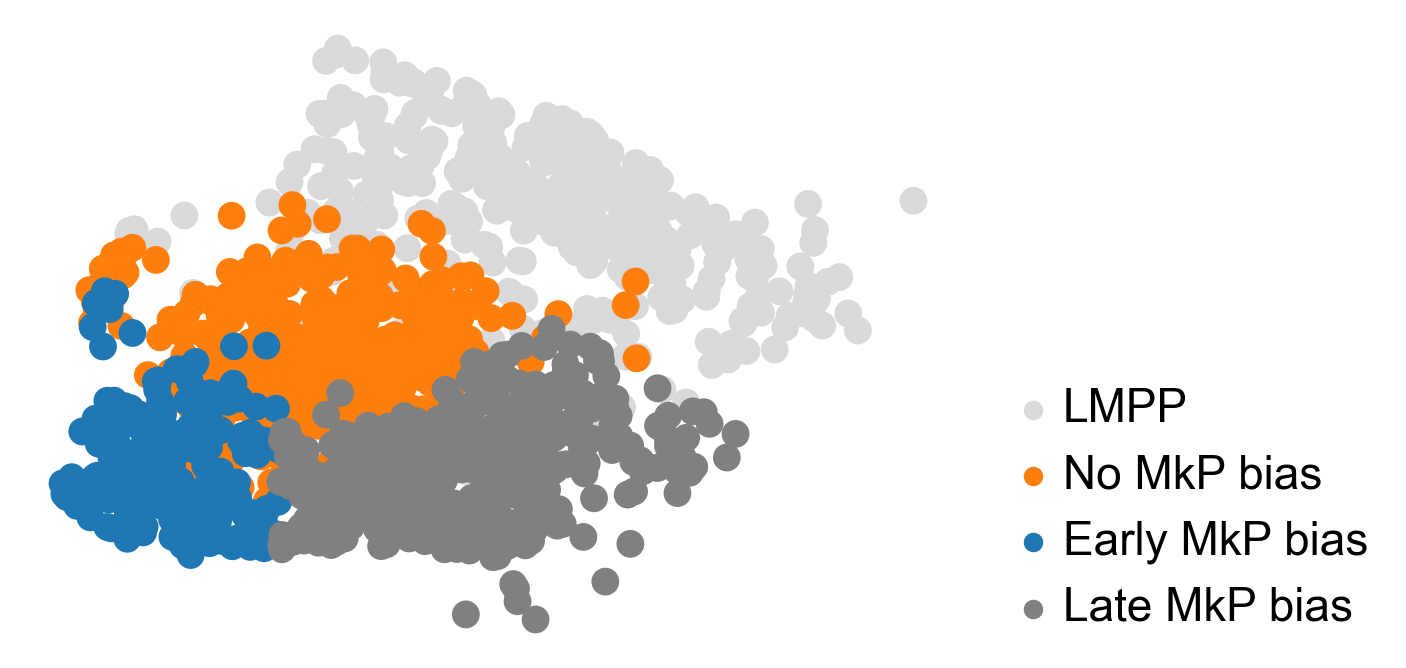

In [59]:
cs.pl.plot_adata_with_prefered_order(adata,'Fate_bias',plot_order=['LMPP','No MkP bias','Early MkP bias','Late MkP bias' ],
                              palette={'LMPP':'#d9d9d9','No MkP bias':'#ff7f0e','Early MkP bias':'#1f77b4','Late MkP bias':'grey'},
                              linewidth = 0,s=100)
#plt.tight_layout()
plt.savefig(f'{figure_path}/X_emb_fate_bias_MkP.pdf')

/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


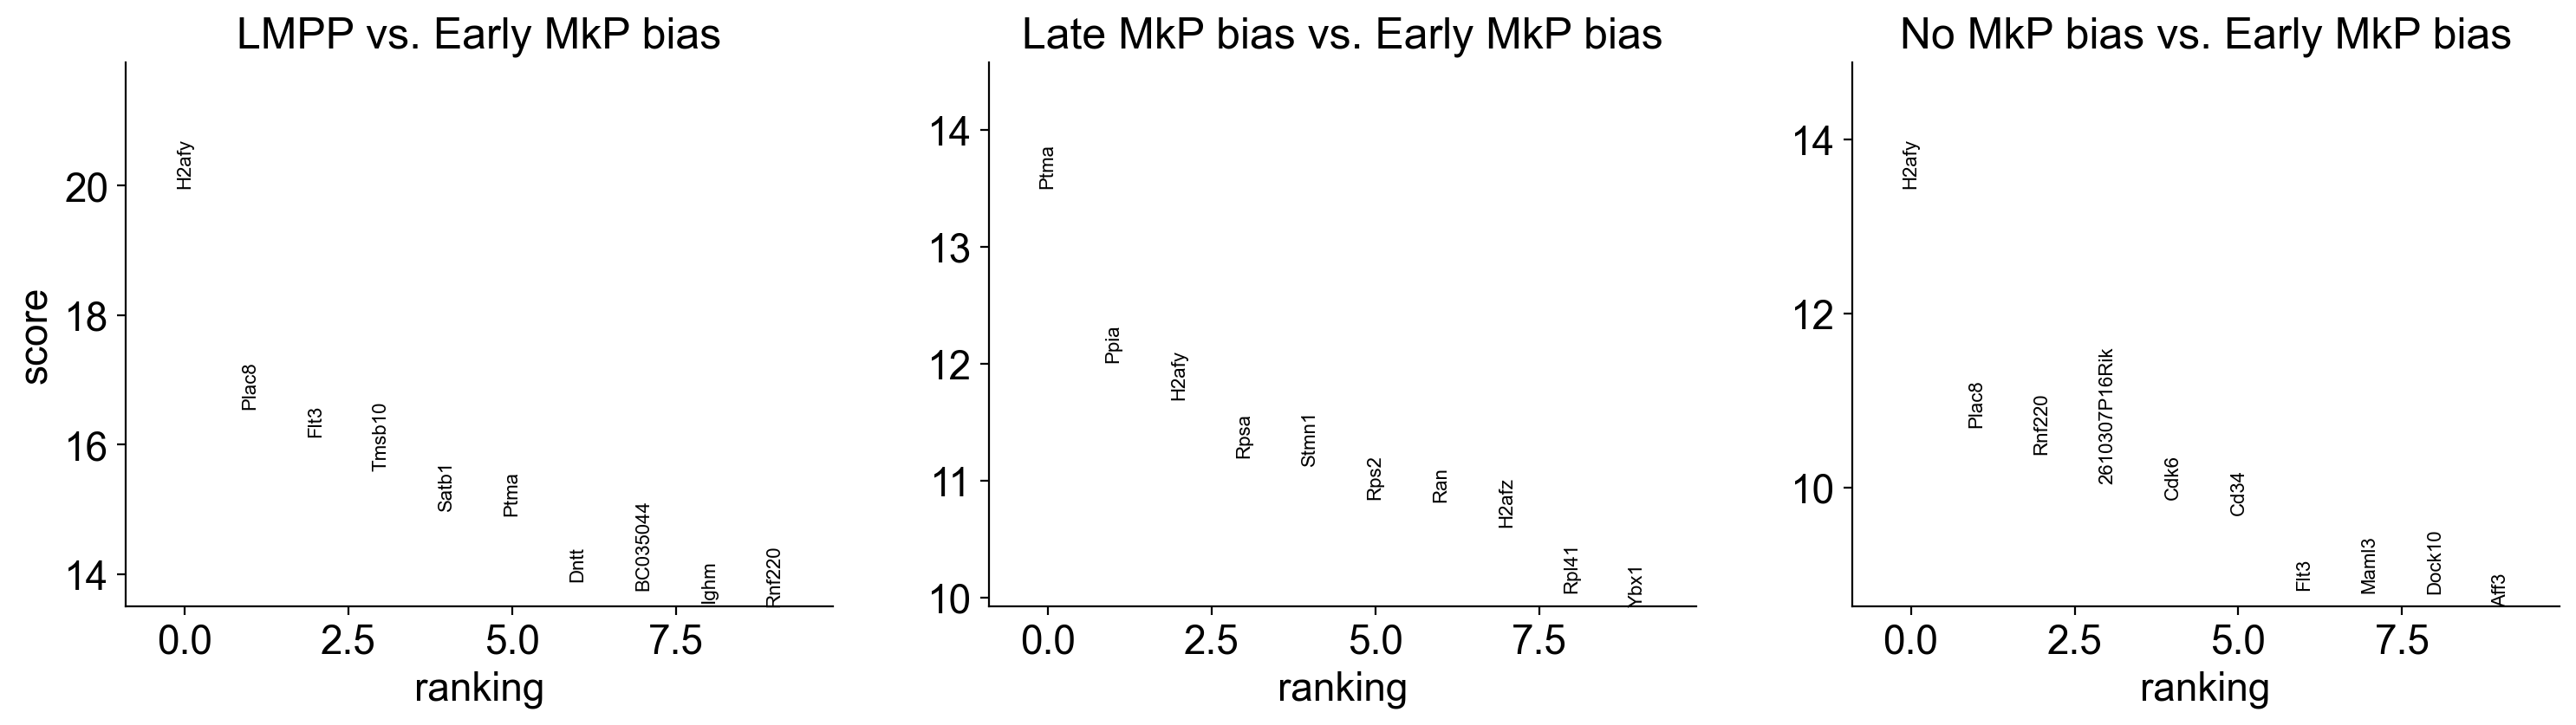

/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:796: RuntimeWarning: overflow encountered in expm1
  (expm1_func(mean_in_cluster) + 1e-9)
/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:797: RuntimeWarning: overflow encountered in expm1
  / (expm1_func(mean_out_cluster) + 1e-9)
/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:796: RuntimeWarning: invalid value encountered in divide
  (expm1_func(mean_in_cluster) + 1e-9)
/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:796: RuntimeWarning: overflow encountered in expm1
  (expm1_func(mean_in_cluster) + 1e-9)
/Users/shouwen/opt/miniconda3/envs/CoSpar_test/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:797: RuntimeWarning: overflow encountered in expm1
  / (expm1_func(mean_out_clust

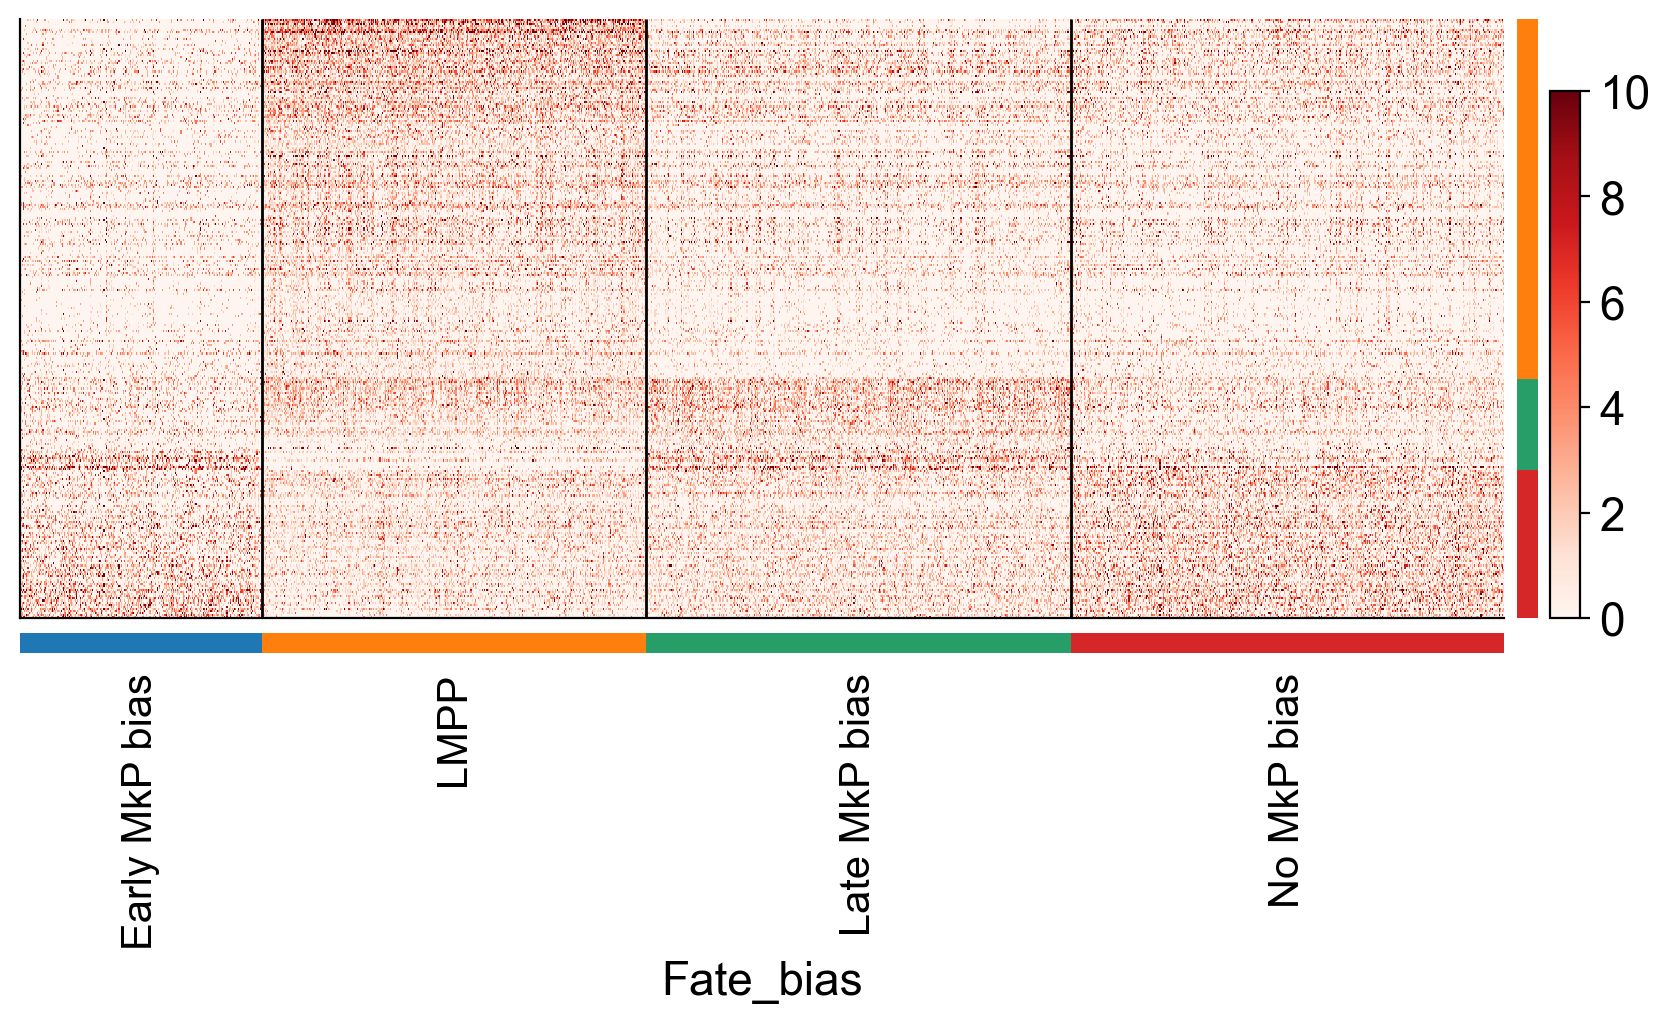

In [60]:
make_gene_heatmap=True
if make_gene_heatmap:
    sc.tl.rank_genes_groups(adata_sub, 'Fate_bias', method='wilcoxon',reference='Early MkP bias')
    sc.pl.rank_genes_groups(adata_sub, n_genes=10, sharey=False)

    adata_sub_1=adata_sub[~pd.isna(adata_sub.obs['Fate_bias'])]
    sc.tl.filter_rank_genes_groups(adata_sub_1)
    sc.pl.rank_genes_groups_heatmap(adata_sub_1, n_genes=200, key='rank_genes_groups_filtered',
                                    swap_axes=True, use_raw=False, vmax=10, vmin=0, cmap='Reds', dendrogram=False,save='gene_heatmap')

In [61]:
cluster_name='No MkP bias'
df_DGE=pd.DataFrame({'logfoldchanges':pd.DataFrame(adata_sub_1.uns['rank_genes_groups']['logfoldchanges'])[cluster_name],
'logpvalue': -np.log10(pd.DataFrame(adata_sub_1.uns['rank_genes_groups']['pvals_adj'])[cluster_name]),
'gene': pd.DataFrame(adata_sub_1.uns['rank_genes_groups']['names'])[cluster_name]})
                       

cluster_name='Late MkP bias'
df_DGE_1=pd.DataFrame({'logfoldchanges':pd.DataFrame(adata_sub_1.uns['rank_genes_groups']['logfoldchanges'])[cluster_name],
'logpvalue': -np.log10(pd.DataFrame(adata_sub_1.uns['rank_genes_groups']['pvals_adj'])[cluster_name]),
'gene': pd.DataFrame(adata_sub_1.uns['rank_genes_groups']['names'])[cluster_name]})

df_DGE_all=pd.concat([df_DGE,df_DGE_1],ignore_index=True)

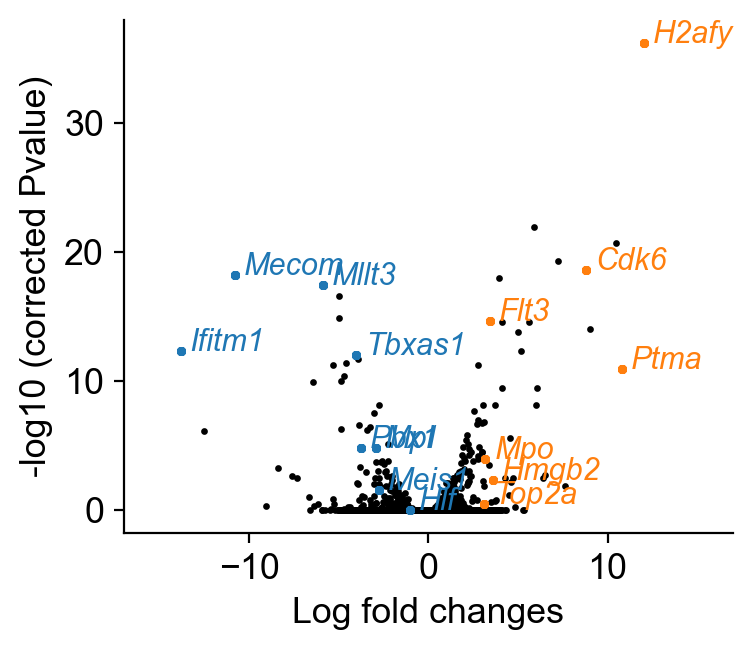

In [62]:
cs.settings.set_figure_params(pointsize=10)
fig,ax=plt.subplots(figsize=(4,3.5))
plt.scatter(df_DGE['logfoldchanges'],
            df_DGE['logpvalue'],
            s=2,color='k')
plt.xlim([-17,17])

DGE_genes_1=['Hlf','Mecom','Mpl','Mllt3','Tbxas1','Ifitm1',
                                 'Pbx1','Meis1',]
DGE_genes_2=['H2afy','Ptma','Cdk6','Mpo','Flt3','Hmgb2','Top2a']

# DGE_genes_1=df_DGE[(df_DGE['logfoldchanges']<0) & (df_DGE['logpvalue']>3)].assign(filter=lambda x: x['gene'].isin(highlighted)).query('filter==True')['gene'].to_list()
# DGE_genes_2=df_DGE[(df_DGE['logfoldchanges']>0) & (df_DGE['logpvalue']>3)].assign(filter=lambda x: x['gene'].isin(highlighted)).query('filter==True')['gene'].to_list()

for g in DGE_genes_1:
    color='#1f77b4'
    df_DGE_sel=df_DGE[df_DGE['gene'].isin(DGE_genes_1)]
    plt.scatter(df_DGE_sel['logfoldchanges'],
                df_DGE_sel['logpvalue'],
                s=5,color=color)

    tmp=df_DGE[df_DGE['gene']==g].values[0]
    ax.text(tmp[0]+0.5, tmp[1]+0, tmp[2],fontsize=11,color=color,style='italic')
    
for g in DGE_genes_2:
    color='#ff7f0e'
    df_DGE_sel=df_DGE[df_DGE['gene'].isin(DGE_genes_2)]
    plt.scatter(df_DGE_sel['logfoldchanges'],
                df_DGE_sel['logpvalue'],
                s=5,color=color)
    
    tmp=df_DGE[df_DGE['gene']==g].values[0]
    ax.text(tmp[0]+0.5, tmp[1]+0, tmp[2],fontsize=11,color=color,style='italic')

plt.xlabel('Log fold changes')
plt.ylabel('-log10 (corrected Pvalue)')
plt.tight_layout()
plt.savefig(f'{figure_path}/DGE_analysis_MkP.pdf')

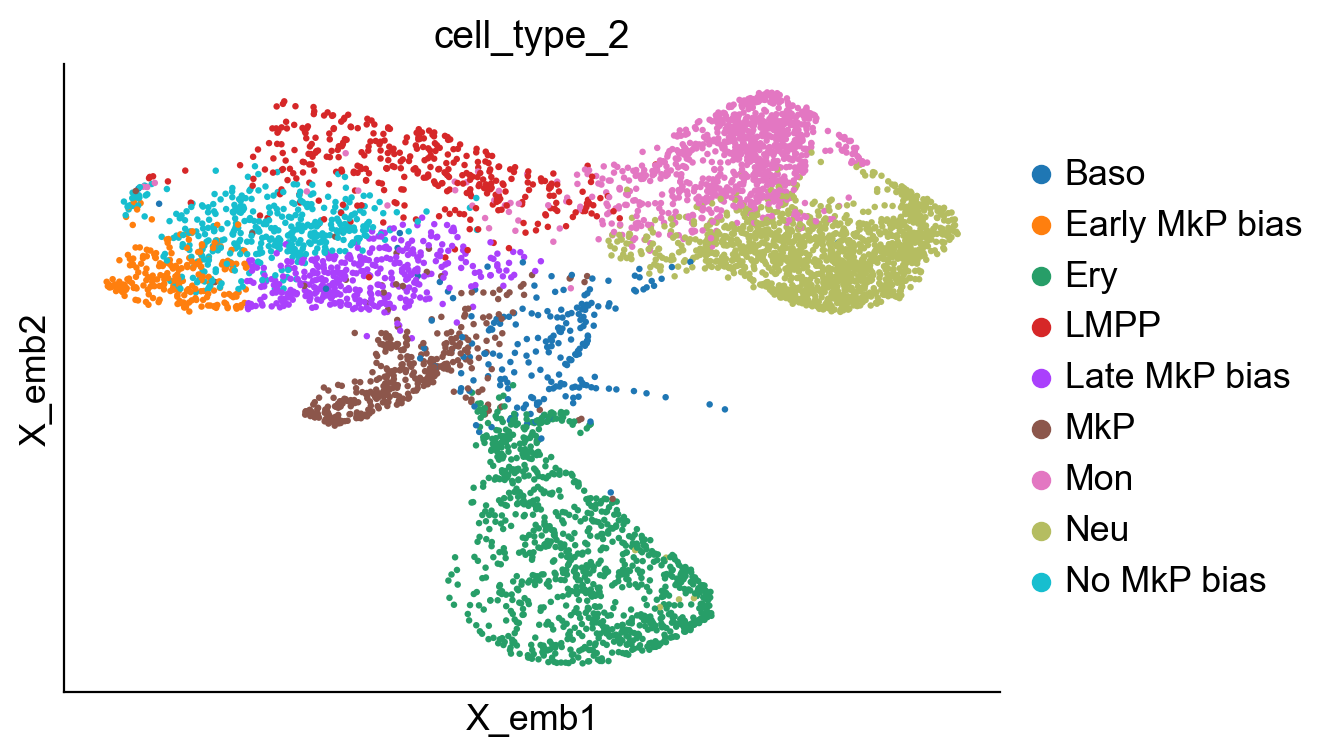

In [63]:
adata.obs['cell_type_2']=adata.obs['cell_type'].astype(str)
adata.obs.loc[adata.obs_names.isin(adata_sub.obs_names),'cell_type_2']=adata_sub.obs['Fate_bias']
cs.pl.embedding(adata,color='cell_type_2')

--> Using zscore (range: [-2,2], or [-1,1]


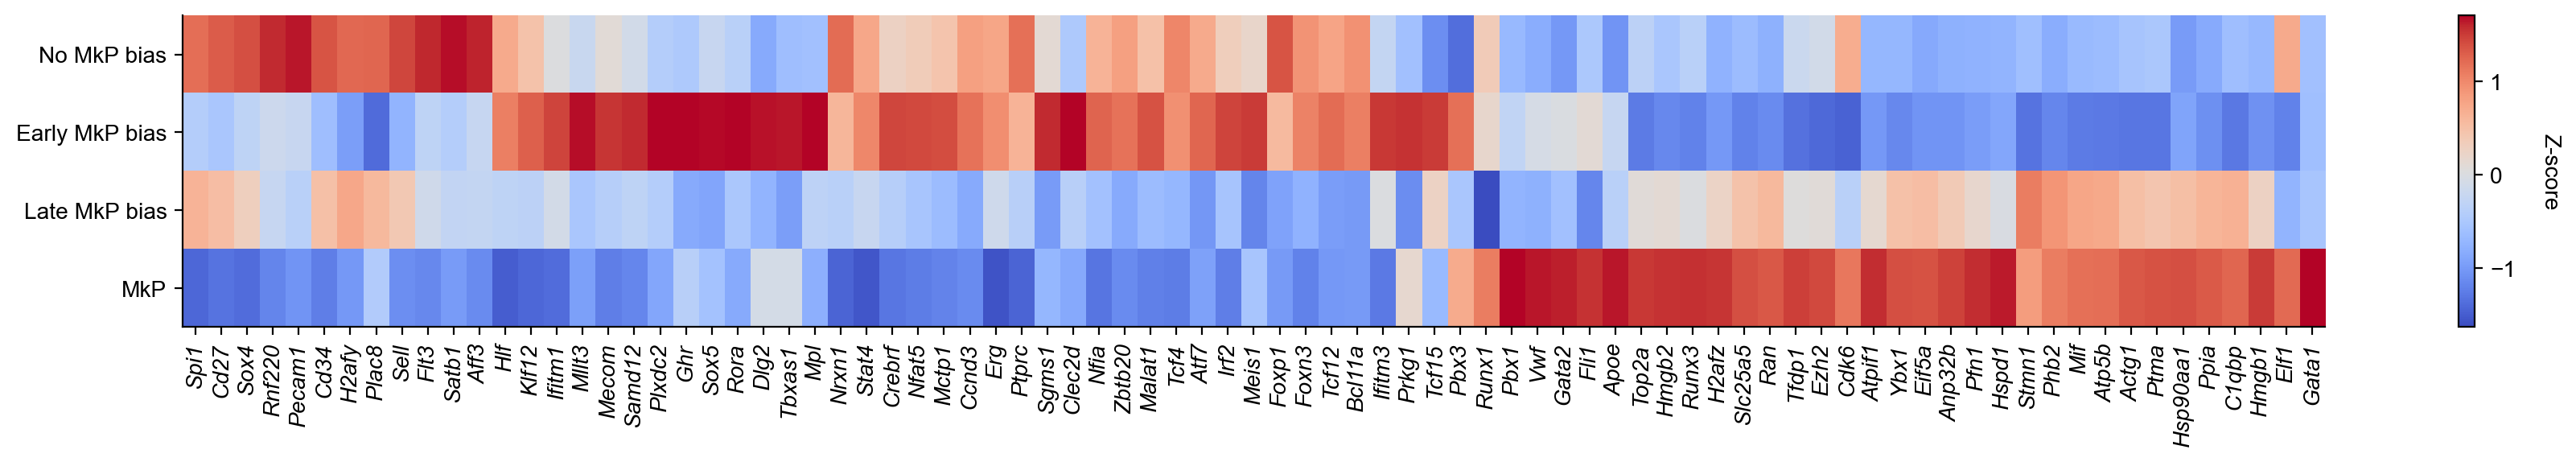

In [64]:
cs.settings.set_figure_params(fontsize=11)
cs.settings.verbosity=3
adata.obs['state_info']=adata.obs['cell_type_2']
# sel_genes=list(set(list(highlighted)+df_DGE_all[(df_DGE_all['logpvalue']>12)]['gene'].to_list()))
# sel_genes=[x for x in sel_genes if 'Rp' not in x]

sel_genes=[ 'Spi1','Cd27','Sox4','Rnf220','Pecam1','Cd34','H2afy','Plac8','Sell','Flt3','Satb1','Aff3', 'Hlf','Klf12','Ifitm1',
 'Mllt3','Mecom','Samd12','Plxdc2','Ghr','Sox5','Rora',
 'Dlg2', 'Tbxas1', 'Mpl', 'Nrxn1', 'Stat4', 'Crebrf',
       'Nfat5', 'Mctp1', 'Ccnd3', 'Erg', 'Ptprc', 'Sgms1', 'Clec2d',
       'Nfia', 'Zbtb20', 'Malat1', 'Tcf4', 'Atf7', 'Irf2', 'Meis1',
       'Foxp1', 'Foxn3', 'Tcf12', 'Bcl11a', 'Ifitm3',  'Prkg1',
       'Tcf15','Pbx3', 'Runx1',
'Pbx1','Vwf','Gata2','Fli1','Apoe','Top2a','Hmgb2','Runx3','H2afz','Slc25a5','Ran','Tfdp1','Ezh2',
 'Cdk6','Atpif1','Ybx1','Eif5a','Anp32b','Pfn1','Hspd1','Stmn1',
 'Phb2','Mif','Atp5b','Actg1','Ptma','Hsp90aa1','Ppia','C1qbp','Hmgb1','Elf1','Gata1']


matrix=cs.pl.gene_expression_heatmap(adata,selected_genes=sel_genes,
                              selected_fates=['No MkP bias', 'Early MkP bias','Late MkP bias','MkP'],
                             fig_width=18,fig_height=3,order_map_y=False,order_map_x=False,print_ordered_labels=False,method='zscore')
adata.obs['state_info']=adata.obs['cell_type']
plt.tight_layout()
plt.savefig(f'{figure_path}/DGE_analysis_MkP_heatmap.pdf')

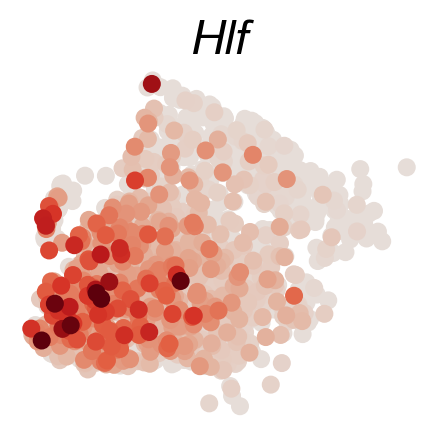

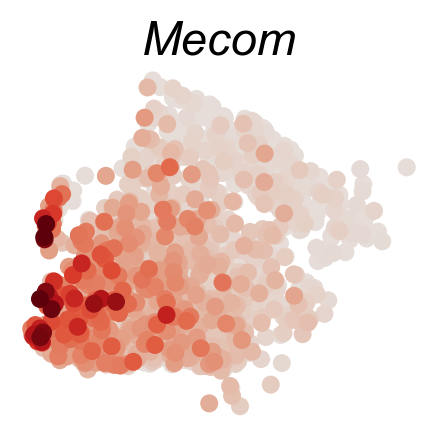

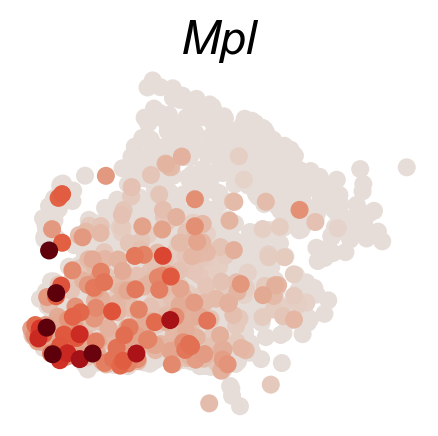

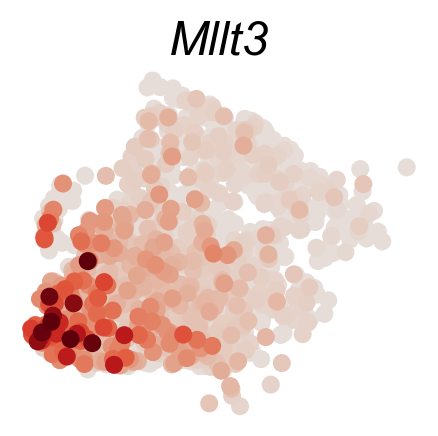

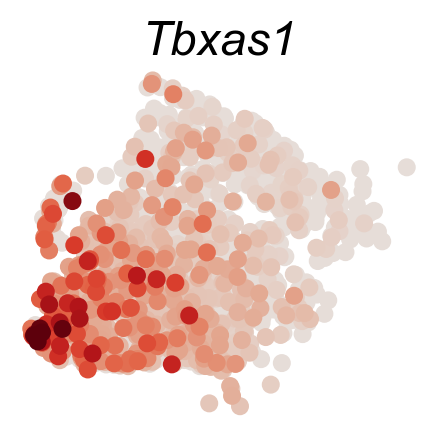

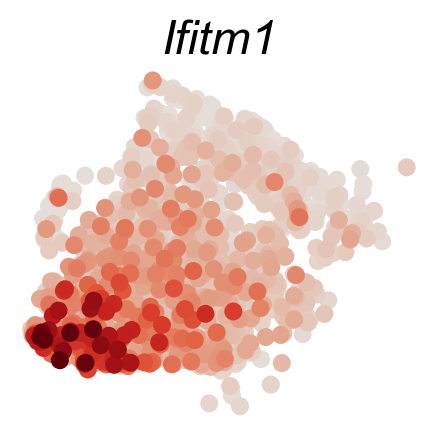

In [65]:
DGE_genes=['Hlf','Mecom','Mpl','Mllt3','Tbxas1','Ifitm1']
#DGE_genes=['Pbx1','Apoe']

cs.settings.set_figure_params(figsize=(2.5,2.5),pointsize=30,fontsize=17)
cs.pl.gene_expression_on_manifold(adata_sub,DGE_genes,savefig=True)

## Fate bias and pseudotime

Results saved at adata.obs['fate_map_transition_map_MkP']
Results saved at adata.obs['fate_map_transition_map_Ery_Neu_Mon_LMPP']
Results saved at adata.obs['fate_bias_transition_map_MkP*Ery_Neu_Mon_LMPP']


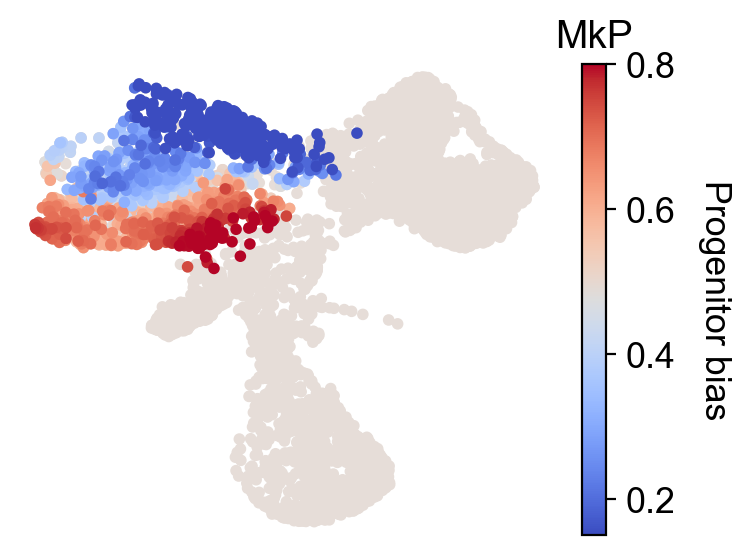

In [66]:
cs.settings.set_figure_params(figsize=(3,3),pointsize=10)
selected_fates=["MkP", ["Ery",'Neu','Mon','LMPP']]
cs.tl.fate_bias(
    adata,
    selected_fates=selected_fates,
    source="transition_map",
    pseudo_count=0,
)
cs.pl.fate_bias(
    adata,
    selected_fates=selected_fates,
    source="transition_map",
    plot_target_state=False,
    vmax=0.8,
    vmin=0.15,
)

Results saved at adata.obs['fate_map_transition_map_MkP']
Results saved at adata.obs['fate_map_transition_map_Ery_Neu_Mon_LMPP']
Results saved at adata.obs['fate_bias_transition_map_MkP*Ery_Neu_Mon_LMPP']
Results saved at adata.obs[f'progenitor_transition_map_MkP'] and adata.obs[f'diff_trajectory_transition_map_MkP']
Results saved at adata.obs[f'progenitor_transition_map_Ery_Neu_Mon_LMPP'] and adata.obs[f'diff_trajectory_transition_map_Ery_Neu_Mon_LMPP']


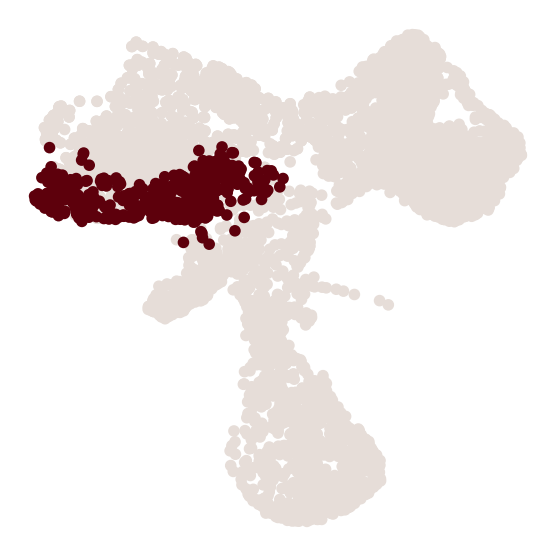

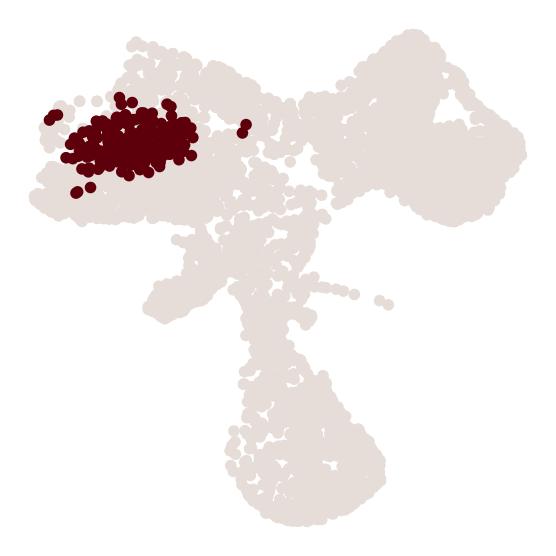

In [67]:
cs.tl.progenitor(
    adata,
    selected_fates=selected_fates,
    source="transition_map",
    map_backward=True,
    bias_threshold_A=0.6,
    bias_threshold_B=0.4,
    sum_fate_prob_thresh=0.2,
    avoid_target_states=True,
)
cs.pl.progenitor(
    adata, selected_fates=selected_fates, source="transition_map"
)

In [70]:
cs.settings.set_figure_params(figsize=(4,4),pointsize=10,fontsize=15)
gene_name_list = ['Mecom', "Vwf",'Mpl','Tbxas1','Ifitm1',
                                 'Meis1']
selected_fate = "MkP"
cs.pl.gene_expression_dynamics(
    adata,
    selected_fate,
    gene_name_list,
    traj_threshold=0.2,
    invert_PseudoTime=False,
    compute_new=True,
    gene_exp_percentile=99,
    n_neighbors=8,
    plot_raw_data=False,
    ggplot_font_size=17,
)